In [14]:
import sys
import arrow
import numpy as np
from numpy.linalg import norm

class PMF(object):
    '''
    Probabilistic Matrix Factorization
    '''

    def __init__(self, n_feature, epsilon, lam, n_epoches, n_batches):
        self.n_feature = n_feature  # number of features
        self.epsilon   = epsilon    # epsilon for leanring rate
        self.lam       = lam        # lambda for L2 regularization

        self.n_epoches = n_epoches  # number of epoches
        self.n_batches = n_batches  # number of batches

        self.V = None # items feature matrix
        self.U = None # users feature matrix
        self.train_loss = []
        self.test_loss = []
        self.test_mse = []

    def loss(self, ratings):
        '''
        Loss Function for evaluating matrix U and V
        '''
        errors = [
            (float(r_ij) - np.dot(self.U[int(i)], self.V[int(j)].T))**2 + \
            self.lam * norm(self.U[int(i)]) + self.lam * norm(self.V[int(j)])
            for i, j, r_ij in ratings]
        return sum(errors)
    
    def squared_error(self, ratings):
        return sum([(float(r_ij) - np.dot(self.U[int(i)], self.V[int(j)].T))**2 for i, j, r_ij in ratings ]) 

    def sgd_update(self, ratings):
        '''
        Update matrix U and V by Stochastic Gradient Descent.
        '''
        for i, j, r_ij in ratings:
            i = int(i)
            j = int(j)
            r_ij_hat = np.dot(self.U[i], self.V[j].T)
            grad_U_i = (r_ij_hat - float(r_ij)) * self.V[j] + self.lam * self.U[i]
            grad_V_j = (r_ij_hat - float(r_ij)) * self.U[i] + self.lam * self.V[j]
            self.U[i] = self.U[i] - self.epsilon * grad_U_i
            self.V[j] = self.V[j] - self.epsilon * grad_V_j

    def fit(self, train_ratings, test_ratings):
        '''
        Fit PMF model with respect to the ratings. A rating is a triple (user,
        item, rating), in particular, user and item are integers to indicate
        unique ids respectively, and rating is a real value score that associates
        with corresponding user and item. For here, ratings is a numpy array
        with shape (n, 3).

        Params:
        - train_ratings: ratings entries for training purpose
        - test_ratings:  ratings entries for testing purpose
        '''
        # get number of training samples and testing samples
        n_trains = train_ratings.shape[0]
        n_tests  = test_ratings.shape[0]
        # get number of items and number of users
        n_users  = int(max(np.amax(train_ratings[:, 0]), np.amax(test_ratings[:, 0]))) + 1
        n_items  = int(max(np.amax(train_ratings[:, 1]), np.amax(test_ratings[:, 1]))) + 1
        # Initialization
        if self.V is None or self.U is None:
            self.e = 0
            self.U = 0.1 * np.random.randn(n_users, self.n_feature)
            self.V = 0.1 * np.random.randn(n_items, self.n_feature)
        # training iterations over epoches
        while self.e < self.n_epoches:
            self.e += 1
            # shuffle training samples
            shuffled_order = np.arange(n_trains)
            np.random.shuffle(shuffled_order)
            # training iterations over batches
            avg_train_loss = []
            avg_test_loss  = []
            batch_size     = int(n_trains / self.n_batches)
            for batch in range(self.n_batches):
                idx       = np.arange(batch_size * batch, batch_size * (batch + 1))
                batch_idx = np.mod(idx, n_trains).astype('int32')
                # training ratings selected in current batch
                batch_ratings = train_ratings[shuffled_order[batch_idx], :]
                # test ratings sample with the same size as the training batch
                sample_test_ratings = test_ratings[np.random.choice(n_tests, batch_size), :]
                # update U and V by sgd in a close-formed gradient
                self.sgd_update(batch_ratings)
                # loss for training and testing U, V and ratings
                train_loss = self.loss(batch_ratings)
                test_loss  = self.loss(sample_test_ratings)
                avg_train_loss.append(train_loss)
                avg_test_loss.append(test_loss)
                
            # training log ouput
            rmse = (self.squared_error(test_ratings) / float(len(test_ratings)))
            avg_train_loss = np.mean(avg_train_loss) / float(batch_size)
            avg_test_loss  = np.mean(avg_test_loss) / float(batch_size)
            self.train_loss.append(avg_train_loss)
            self.test_loss.append(avg_test_loss)
            self.test_mse.append(rmse)
            print('[%s] Epoch %d' % (arrow.now(), self.e), file=sys.stderr)
            print('[%s] Training loss:\t%f' % (arrow.now(), avg_train_loss), file=sys.stderr)
            print('[%s] Testing loss:\t%f' % (arrow.now(), avg_test_loss), file=sys.stderr)
            print('[%s] Testing MSE:\t%f' % (arrow.now(), rmse), file=sys.stderr)



In [16]:
import pandas as pd
import numpy as np
import math

In [17]:
ratingsdf = pd.read_csv('Ratings.csv')
ratings = ratingsdf.to_numpy()
shuffled_order = np.arange(len(ratings))
np.random.shuffle(shuffled_order)
ratings        = ratings[shuffled_order]
# cross validation
divide_on = math.floor(len(ratings)*0.75)
train_ratings  = ratings[0:divide_on :]
test_ratings   = ratings[divide_on: :]
print('training:', train_ratings.shape)
print('testing:', test_ratings.shape)
pmf = PMF(n_feature=100, epsilon=0.1, lam=0.1, n_epoches=100, n_batches=1000)
pmf.fit(train_ratings, test_ratings)

training: (426339, 3)
testing: (142114, 3)


[2020-04-04T22:55:27.925730+08:00] Epoch 1
[2020-04-04T22:55:27.925730+08:00] Training loss:	6.637968
[2020-04-04T22:55:27.926732+08:00] Testing loss:	15.174951
[2020-04-04T22:55:27.926732+08:00] Testing MSE:	11.820982
[2020-04-04T22:55:49.827770+08:00] Epoch 2
[2020-04-04T22:55:49.827770+08:00] Training loss:	1.784388
[2020-04-04T22:55:49.827770+08:00] Testing loss:	12.034733
[2020-04-04T22:55:49.827770+08:00] Testing MSE:	11.287718
[2020-04-04T22:56:11.677731+08:00] Epoch 3
[2020-04-04T22:56:11.677731+08:00] Training loss:	0.772624
[2020-04-04T22:56:11.677731+08:00] Testing loss:	11.692321
[2020-04-04T22:56:11.677731+08:00] Testing MSE:	11.144245
[2020-04-04T22:56:40.922731+08:00] Epoch 4
[2020-04-04T22:56:40.923358+08:00] Training loss:	0.542890
[2020-04-04T22:56:40.923784+08:00] Testing loss:	11.569023
[2020-04-04T22:56:40.923784+08:00] Testing MSE:	11.069566
[2020-04-04T22:57:07.778732+08:00] Epoch 5
[2020-04-04T22:57:07.778732+08:00] Training loss:	0.495733
[2020-04-04T22:57:07.7

[2020-04-04T23:09:40.825372+08:00] Epoch 39
[2020-04-04T23:09:40.825372+08:00] Training loss:	0.447470
[2020-04-04T23:09:40.825372+08:00] Testing loss:	10.707217
[2020-04-04T23:09:40.825372+08:00] Testing MSE:	10.304742
[2020-04-04T23:10:02.674409+08:00] Epoch 40
[2020-04-04T23:10:02.674409+08:00] Training loss:	0.447099
[2020-04-04T23:10:02.674409+08:00] Testing loss:	10.710690
[2020-04-04T23:10:02.675372+08:00] Testing MSE:	10.290591
[2020-04-04T23:10:24.254372+08:00] Epoch 41
[2020-04-04T23:10:24.255373+08:00] Training loss:	0.446804
[2020-04-04T23:10:24.255373+08:00] Testing loss:	10.677969
[2020-04-04T23:10:24.255373+08:00] Testing MSE:	10.281088
[2020-04-04T23:10:46.781372+08:00] Epoch 42
[2020-04-04T23:10:46.782372+08:00] Training loss:	0.446489
[2020-04-04T23:10:46.782372+08:00] Testing loss:	10.680837
[2020-04-04T23:10:46.783371+08:00] Testing MSE:	10.265432
[2020-04-04T23:11:08.225369+08:00] Epoch 43
[2020-04-04T23:11:08.225369+08:00] Training loss:	0.446205
[2020-04-04T23:11

[2020-04-04T23:23:39.307298+08:00] Epoch 77
[2020-04-04T23:23:39.307298+08:00] Training loss:	0.439531
[2020-04-04T23:23:39.307298+08:00] Testing loss:	10.325092
[2020-04-04T23:23:39.308266+08:00] Testing MSE:	9.921743
[2020-04-04T23:24:01.157265+08:00] Epoch 78
[2020-04-04T23:24:01.158229+08:00] Training loss:	0.439370
[2020-04-04T23:24:01.158229+08:00] Testing loss:	10.341288
[2020-04-04T23:24:01.158229+08:00] Testing MSE:	9.915132
[2020-04-04T23:24:23.830189+08:00] Epoch 79
[2020-04-04T23:24:23.831193+08:00] Training loss:	0.439215
[2020-04-04T23:24:23.831193+08:00] Testing loss:	10.293500
[2020-04-04T23:24:23.831193+08:00] Testing MSE:	9.906403
[2020-04-04T23:24:45.618952+08:00] Epoch 80
[2020-04-04T23:24:45.618952+08:00] Training loss:	0.439085
[2020-04-04T23:24:45.618952+08:00] Testing loss:	10.326908
[2020-04-04T23:24:45.618952+08:00] Testing MSE:	9.901272
[2020-04-04T23:25:08.977200+08:00] Epoch 81
[2020-04-04T23:25:08.977200+08:00] Training loss:	0.439012
[2020-04-04T23:25:08.

[6.63796779371572, 1.7843879856208513, 0.772623715871277, 0.5428899007248871, 0.4957331434990553, 0.4827452706822773, 0.47685075721925396, 0.47336758420877706, 0.4707362105488676, 0.46863528660230513, 0.4668516274600586, 0.4652712009291881, 0.46386281075147023, 0.4626326793800302, 0.46143013334246513, 0.4603758044122955, 0.45938814417626994, 0.45847897492315093, 0.4575773166726152, 0.45679005952738133, 0.45612149126695084, 0.4553555987493786, 0.45474048696760455, 0.4540898430681131, 0.4535136963764526, 0.4529344724514985, 0.45242837221993076, 0.451906693978208, 0.45141642788516473, 0.45091186055074434, 0.4504741254354399, 0.45005978858388906, 0.4496481470874442, 0.44919634228442024, 0.4488622670796134, 0.44853331493928467, 0.44811638101226936, 0.4477689907080009, 0.4474703343805132, 0.44709866984281593, 0.44680408544855515, 0.446488734134605, 0.4462049405521148, 0.44593943724635304, 0.44565193411956955, 0.4453847161167846, 0.4451360769180097, 0.44484709325610505, 0.4446013245283105, 0.

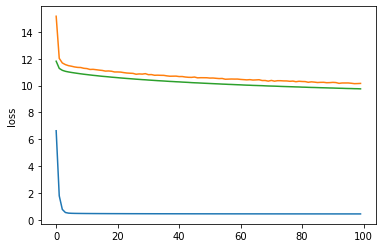

In [18]:
import matplotlib.pyplot as plt
print(pmf.train_loss, pmf.test_loss, pmf.test_mse)
plt.plot(pmf.train_loss)
plt.plot(pmf.test_loss)
plt.plot(pmf.test_mse)

plt.ylabel('loss')
plt.show()

training: (294796, 3)
testing: (98266, 3)


[2020-04-04T23:32:27.426740+08:00] Epoch 1
[2020-04-04T23:32:27.426740+08:00] Training loss:	5.620975
[2020-04-04T23:32:27.426740+08:00] Testing loss:	13.212585
[2020-04-04T23:32:27.426740+08:00] Testing MSE:	8.423829
[2020-04-04T23:32:43.349545+08:00] Epoch 2
[2020-04-04T23:32:43.349545+08:00] Training loss:	1.261686
[2020-04-04T23:32:43.349545+08:00] Testing loss:	8.406701
[2020-04-04T23:32:43.350517+08:00] Testing MSE:	7.440124
[2020-04-04T23:32:58.548886+08:00] Epoch 3
[2020-04-04T23:32:58.549891+08:00] Training loss:	0.632791
[2020-04-04T23:32:58.549891+08:00] Testing loss:	7.879786
[2020-04-04T23:32:58.549891+08:00] Testing MSE:	7.263995
[2020-04-04T23:33:13.998999+08:00] Epoch 4
[2020-04-04T23:33:13.998999+08:00] Training loss:	0.517471
[2020-04-04T23:33:13.998999+08:00] Testing loss:	7.669426
[2020-04-04T23:33:14.000003+08:00] Testing MSE:	7.147363
[2020-04-04T23:33:29.324278+08:00] Epoch 5
[2020-04-04T23:33:29.325275+08:00] Training loss:	0.491974
[2020-04-04T23:33:29.325275+0

[2020-04-04T23:42:10.002235+08:00] Epoch 39
[2020-04-04T23:42:10.003789+08:00] Training loss:	0.451027
[2020-04-04T23:42:10.003789+08:00] Testing loss:	6.460308
[2020-04-04T23:42:10.004207+08:00] Testing MSE:	6.001876
[2020-04-04T23:42:25.173731+08:00] Epoch 40
[2020-04-04T23:42:25.173731+08:00] Training loss:	0.450773
[2020-04-04T23:42:25.173731+08:00] Testing loss:	6.434856
[2020-04-04T23:42:25.173731+08:00] Testing MSE:	5.981101
[2020-04-04T23:42:40.680601+08:00] Epoch 41
[2020-04-04T23:42:40.680601+08:00] Training loss:	0.450495
[2020-04-04T23:42:40.680601+08:00] Testing loss:	6.410909
[2020-04-04T23:42:40.680601+08:00] Testing MSE:	5.963040
[2020-04-04T23:42:55.775133+08:00] Epoch 42
[2020-04-04T23:42:55.775133+08:00] Training loss:	0.450103
[2020-04-04T23:42:55.776136+08:00] Testing loss:	6.379493
[2020-04-04T23:42:55.776136+08:00] Testing MSE:	5.949081
[2020-04-04T23:43:11.440009+08:00] Epoch 43
[2020-04-04T23:43:11.440009+08:00] Training loss:	0.449859
[2020-04-04T23:43:11.4400

[2020-04-04T23:51:55.242189+08:00] Epoch 77
[2020-04-04T23:51:55.242189+08:00] Training loss:	0.443633
[2020-04-04T23:51:55.242189+08:00] Testing loss:	5.857260
[2020-04-04T23:51:55.243190+08:00] Testing MSE:	5.416869
[2020-04-04T23:52:10.592818+08:00] Epoch 78
[2020-04-04T23:52:10.593174+08:00] Training loss:	0.443460
[2020-04-04T23:52:10.593174+08:00] Testing loss:	5.808653
[2020-04-04T23:52:10.593174+08:00] Testing MSE:	5.403625
[2020-04-04T23:52:25.859407+08:00] Epoch 79
[2020-04-04T23:52:25.860409+08:00] Training loss:	0.443305
[2020-04-04T23:52:25.860409+08:00] Testing loss:	5.804626
[2020-04-04T23:52:25.860409+08:00] Testing MSE:	5.391515
[2020-04-04T23:52:41.640048+08:00] Epoch 80
[2020-04-04T23:52:41.640048+08:00] Training loss:	0.443166
[2020-04-04T23:52:41.640048+08:00] Testing loss:	5.783900
[2020-04-04T23:52:41.640048+08:00] Testing MSE:	5.378875
[2020-04-04T23:52:57.152116+08:00] Epoch 81
[2020-04-04T23:52:57.152116+08:00] Training loss:	0.443120
[2020-04-04T23:52:57.1521

[5.620974831261482, 1.2616859175061326, 0.6327914271443333, 0.517471060399788, 0.49197385287390255, 0.48330265543975914, 0.4789181665313553, 0.47600685221182015, 0.47366534757577133, 0.4717279162494431, 0.4699439208642728, 0.46853187980559585, 0.4671234788078381, 0.46598160455321164, 0.46486576240331756, 0.4637341177069202, 0.4627944563442017, 0.4619303621527006, 0.46105685725575685, 0.4603420240435515, 0.45957748330330994, 0.4588939940667851, 0.45820030438025855, 0.45763992962483585, 0.457076296024444, 0.456520504898451, 0.45593860524929103, 0.4554184210645205, 0.4549361325558808, 0.4544942582725461, 0.45409991295268554, 0.45366833000236884, 0.45328095104827465, 0.45280793399358116, 0.45248737927163607, 0.4520830715508712, 0.451745310667892, 0.45135508300490057, 0.45102748702114215, 0.45077293017951525, 0.45049516617423013, 0.45010347247245885, 0.44985946664550297, 0.44950987069555953, 0.4492859651909391, 0.4490621013346758, 0.4487824500381122, 0.4485454654603121, 0.44831020509263997,

[2020-04-04T23:58:03.403411+08:00] Epoch 100
[2020-04-04T23:58:03.403411+08:00] Training loss:	0.441350
[2020-04-04T23:58:03.404377+08:00] Testing loss:	5.598924
[2020-04-04T23:58:03.404377+08:00] Testing MSE:	5.174814


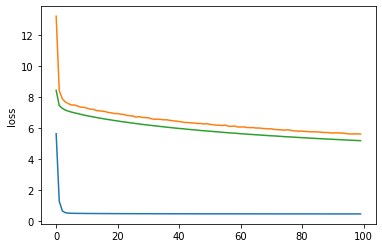

In [19]:
ratingsdf = pd.read_csv('Ratings_vip.csv')
ratings = ratingsdf.to_numpy()
shuffled_order = np.arange(len(ratings))
np.random.shuffle(shuffled_order)
ratings        = ratings[shuffled_order]
# cross validation
divide_on = math.floor(len(ratings)*0.75)
train_ratings  = ratings[0:divide_on :]
test_ratings   = ratings[divide_on: :]
print('training:', train_ratings.shape)
print('testing:', test_ratings.shape)
pmf = PMF(n_feature=100, epsilon=0.1, lam=0.1, n_epoches=100, n_batches=1000)
pmf.fit(train_ratings, test_ratings)
import matplotlib.pyplot as plt
print(pmf.train_loss, pmf.test_loss, pmf.test_mse)
plt.plot(pmf.train_loss)
plt.plot(pmf.test_loss)
plt.plot(pmf.test_mse)

plt.ylabel('loss')
plt.show()

In [20]:
# try Ratings_vip_moderateS.csv
ratingsdf = pd.read_csv('Ratings_vip_moderateS.csv')
ratings = ratingsdf.to_numpy()
shuffled_order = np.arange(len(ratings))
np.random.shuffle(shuffled_order)
ratings        = ratings[shuffled_order]
# cross validation
divide_on = math.floor(len(ratings)*0.75)
train_ratings  = ratings[0:divide_on :]
test_ratings   = ratings[divide_on: :]
print('training:', train_ratings.shape)
print('testing:', test_ratings.shape)
pmf = PMF(n_feature=100, epsilon=0.1, lam=0.1, n_epoches=100, n_batches=1000)
pmf.fit(train_ratings, test_ratings)

training: (294796, 3)
testing: (98266, 3)


[2020-04-04T23:58:20.380269+08:00] Epoch 1
[2020-04-04T23:58:20.381270+08:00] Training loss:	5.171185
[2020-04-04T23:58:20.381270+08:00] Testing loss:	12.488306
[2020-04-04T23:58:20.381270+08:00] Testing MSE:	7.826756
[2020-04-04T23:58:35.941295+08:00] Epoch 2
[2020-04-04T23:58:35.942291+08:00] Training loss:	1.118904
[2020-04-04T23:58:35.942291+08:00] Testing loss:	7.821887
[2020-04-04T23:58:35.942291+08:00] Testing MSE:	6.787191
[2020-04-04T23:58:52.255398+08:00] Epoch 3
[2020-04-04T23:58:52.255398+08:00] Training loss:	0.579201
[2020-04-04T23:58:52.256401+08:00] Testing loss:	7.171686
[2020-04-04T23:58:52.256401+08:00] Testing MSE:	6.638806
[2020-04-04T23:59:07.785955+08:00] Epoch 4
[2020-04-04T23:59:07.785955+08:00] Training loss:	0.492859
[2020-04-04T23:59:07.785955+08:00] Testing loss:	7.051678
[2020-04-04T23:59:07.785955+08:00] Testing MSE:	6.511805
[2020-04-04T23:59:23.337480+08:00] Epoch 5
[2020-04-04T23:59:23.337480+08:00] Training loss:	0.474543
[2020-04-04T23:59:23.337789+0

[2020-04-05T00:08:19.353536+08:00] Epoch 39
[2020-04-05T00:08:19.354778+08:00] Training loss:	0.436987
[2020-04-05T00:08:19.354883+08:00] Testing loss:	5.608014
[2020-04-05T00:08:19.354949+08:00] Testing MSE:	5.167043
[2020-04-05T00:08:35.075358+08:00] Epoch 40
[2020-04-05T00:08:35.075358+08:00] Training loss:	0.436636
[2020-04-05T00:08:35.075358+08:00] Testing loss:	5.608244
[2020-04-05T00:08:35.075358+08:00] Testing MSE:	5.142842
[2020-04-05T00:08:50.345720+08:00] Epoch 41
[2020-04-05T00:08:50.345720+08:00] Training loss:	0.436275
[2020-04-05T00:08:50.345720+08:00] Testing loss:	5.551054
[2020-04-05T00:08:50.345720+08:00] Testing MSE:	5.118163
[2020-04-05T00:09:05.909729+08:00] Epoch 42
[2020-04-05T00:09:05.910694+08:00] Training loss:	0.435928
[2020-04-05T00:09:05.910694+08:00] Testing loss:	5.522256
[2020-04-05T00:09:05.910694+08:00] Testing MSE:	5.093859
[2020-04-05T00:09:21.663723+08:00] Epoch 43
[2020-04-05T00:09:21.663723+08:00] Training loss:	0.435609
[2020-04-05T00:09:21.6637

[2020-04-05T00:18:12.848290+08:00] Epoch 77
[2020-04-05T00:18:12.848290+08:00] Training loss:	0.427875
[2020-04-05T00:18:12.848290+08:00] Testing loss:	4.848415
[2020-04-05T00:18:12.848290+08:00] Testing MSE:	4.431954
[2020-04-05T00:18:28.531059+08:00] Epoch 78
[2020-04-05T00:18:28.531059+08:00] Training loss:	0.427723
[2020-04-05T00:18:28.531505+08:00] Testing loss:	4.832951
[2020-04-05T00:18:28.531505+08:00] Testing MSE:	4.416944
[2020-04-05T00:18:44.447483+08:00] Epoch 79
[2020-04-05T00:18:44.447483+08:00] Training loss:	0.427563
[2020-04-05T00:18:44.447483+08:00] Testing loss:	4.830521
[2020-04-05T00:18:44.447483+08:00] Testing MSE:	4.402294
[2020-04-05T00:19:00.233333+08:00] Epoch 80
[2020-04-05T00:19:00.233827+08:00] Training loss:	0.427403
[2020-04-05T00:19:00.233827+08:00] Testing loss:	4.816247
[2020-04-05T00:19:00.233827+08:00] Testing MSE:	4.387344
[2020-04-05T00:19:15.888014+08:00] Epoch 81
[2020-04-05T00:19:15.889015+08:00] Training loss:	0.427262
[2020-04-05T00:19:15.8890

[5.171185338049304, 1.1189036906140062, 0.5792013388678907, 0.492858686850409, 0.4745432529321324, 0.4684787879231738, 0.4649393893093906, 0.4623212430059885, 0.4601551368186676, 0.45826691136948017, 0.4566344088880351, 0.45514214123574087, 0.4538095103319866, 0.45258971808631165, 0.45147668909615823, 0.4504331007686928, 0.4494677439211983, 0.44857159083802256, 0.44770891915766076, 0.4469267227132859, 0.4461616225073427, 0.44545056168495717, 0.444760354139274, 0.4441294667247426, 0.4435040841185713, 0.44290447346352146, 0.4423519252178864, 0.441815740880076, 0.44128482523550205, 0.4407783966138187, 0.44029828910688434, 0.43983134536790264, 0.43939148552627594, 0.43895667317146003, 0.43853635707889244, 0.43812436182432807, 0.437724273652835, 0.43735364907006236, 0.4369868972202272, 0.4366357000816376, 0.43627469267933205, 0.43592766573912545, 0.4356087116853069, 0.4352844874325442, 0.434962132526122, 0.4346604820858424, 0.4343611705417587, 0.43407030497502896, 0.433800162783735, 0.43350

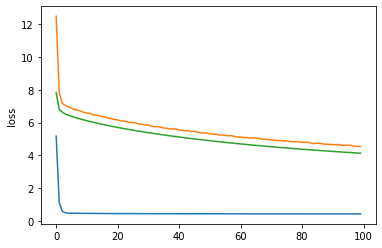

In [21]:
import matplotlib.pyplot as plt
print(pmf.train_loss, pmf.test_loss, pmf.test_mse)
plt.plot(pmf.train_loss)
plt.plot(pmf.test_loss)
plt.plot(pmf.test_mse)

plt.ylabel('loss')
plt.show()

training: (294796, 3)
testing: (98266, 3)


[2020-04-05T00:24:31.573234+08:00] Epoch 1
[2020-04-05T00:24:31.573234+08:00] Training loss:	4.166560
[2020-04-05T00:24:31.573234+08:00] Testing loss:	9.832069
[2020-04-05T00:24:31.573234+08:00] Testing MSE:	6.365807
[2020-04-05T00:24:47.166240+08:00] Epoch 2
[2020-04-05T00:24:47.166240+08:00] Training loss:	1.038729
[2020-04-05T00:24:47.166240+08:00] Testing loss:	6.358392
[2020-04-05T00:24:47.166240+08:00] Testing MSE:	5.486965
[2020-04-05T00:25:03.842928+08:00] Epoch 3
[2020-04-05T00:25:03.842928+08:00] Training loss:	0.540276
[2020-04-05T00:25:03.842928+08:00] Testing loss:	5.890849
[2020-04-05T00:25:03.842928+08:00] Testing MSE:	5.370966
[2020-04-05T00:25:19.825519+08:00] Epoch 4
[2020-04-05T00:25:19.825519+08:00] Training loss:	0.464280
[2020-04-05T00:25:19.826484+08:00] Testing loss:	5.759661
[2020-04-05T00:25:19.826484+08:00] Testing MSE:	5.285645
[2020-04-05T00:25:35.109081+08:00] Epoch 5
[2020-04-05T00:25:35.109081+08:00] Training loss:	0.449465
[2020-04-05T00:25:35.109081+08

[2020-04-05T00:34:23.074464+08:00] Epoch 39
[2020-04-05T00:34:23.074464+08:00] Training loss:	0.416670
[2020-04-05T00:34:23.074464+08:00] Testing loss:	4.835613
[2020-04-05T00:34:23.074464+08:00] Testing MSE:	4.435649
[2020-04-05T00:34:38.537206+08:00] Epoch 40
[2020-04-05T00:34:38.538206+08:00] Training loss:	0.416426
[2020-04-05T00:34:38.538206+08:00] Testing loss:	4.823122
[2020-04-05T00:34:38.538206+08:00] Testing MSE:	4.420840
[2020-04-05T00:34:53.866789+08:00] Epoch 41
[2020-04-05T00:34:53.866789+08:00] Training loss:	0.416126
[2020-04-05T00:34:53.866789+08:00] Testing loss:	4.795058
[2020-04-05T00:34:53.866789+08:00] Testing MSE:	4.405345
[2020-04-05T00:35:09.411932+08:00] Epoch 42
[2020-04-05T00:35:09.411932+08:00] Training loss:	0.415941
[2020-04-05T00:35:09.411932+08:00] Testing loss:	4.796317
[2020-04-05T00:35:09.411932+08:00] Testing MSE:	4.390122
[2020-04-05T00:35:25.021156+08:00] Epoch 43
[2020-04-05T00:35:25.022157+08:00] Training loss:	0.415574
[2020-04-05T00:35:25.0221

[2020-04-05T00:44:15.553317+08:00] Epoch 77
[2020-04-05T00:44:15.553317+08:00] Training loss:	0.409722
[2020-04-05T00:44:15.554025+08:00] Testing loss:	4.399476
[2020-04-05T00:44:15.554164+08:00] Testing MSE:	4.001441
[2020-04-05T00:44:31.117389+08:00] Epoch 78
[2020-04-05T00:44:31.118387+08:00] Training loss:	0.409580
[2020-04-05T00:44:31.118387+08:00] Testing loss:	4.373633
[2020-04-05T00:44:31.118387+08:00] Testing MSE:	3.993286
[2020-04-05T00:44:47.011895+08:00] Epoch 79
[2020-04-05T00:44:47.011895+08:00] Training loss:	0.409544
[2020-04-05T00:44:47.011895+08:00] Testing loss:	4.392371
[2020-04-05T00:44:47.011895+08:00] Testing MSE:	3.984670
[2020-04-05T00:45:02.542359+08:00] Epoch 80
[2020-04-05T00:45:02.542359+08:00] Training loss:	0.409427
[2020-04-05T00:45:02.542359+08:00] Testing loss:	4.393063
[2020-04-05T00:45:02.542359+08:00] Testing MSE:	3.973997
[2020-04-05T00:45:18.345325+08:00] Epoch 81
[2020-04-05T00:45:18.345325+08:00] Training loss:	0.409319
[2020-04-05T00:45:18.3453

[4.166560389596932, 1.0387292602298903, 0.5402763686853657, 0.4642803380519865, 0.4494645739600952, 0.4444224676707675, 0.4412402917510751, 0.43881070274653056, 0.43679240864610547, 0.43519316745283737, 0.43362653363636156, 0.43237283539526156, 0.4311271982581553, 0.4300357630793986, 0.42904426245957045, 0.42812864676029805, 0.42733251432056774, 0.42650459487191755, 0.42575376379875485, 0.4249844017978006, 0.4245029765007746, 0.4238235906853929, 0.4231601599878764, 0.42270288019206675, 0.4221601394958605, 0.4216451126940827, 0.42111740248587004, 0.4207158905585699, 0.420287695083198, 0.41983985466012935, 0.41946198378159877, 0.41900311344766905, 0.4186822193971008, 0.4183018640222437, 0.4180125322664492, 0.417651527534639, 0.41734503804017, 0.4169890186901391, 0.416670409179914, 0.4164256750143731, 0.4161259939566255, 0.41594123781909115, 0.4155736963409748, 0.4153567413482562, 0.4151154918947379, 0.41484203737178243, 0.4145754011016849, 0.4144075217230471, 0.41413329461420156, 0.41396

[2020-04-05T00:50:16.303065+08:00] Epoch 100
[2020-04-05T00:50:16.303065+08:00] Training loss:	0.407549
[2020-04-05T00:50:16.303065+08:00] Testing loss:	4.217453
[2020-04-05T00:50:16.303065+08:00] Testing MSE:	3.826189


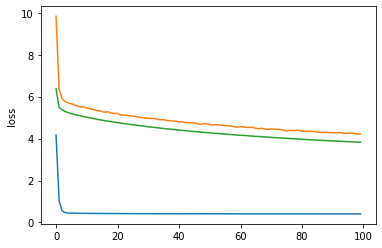

In [22]:
# try Ratings_vip_sa.csv
ratingsdf = pd.read_csv('Ratings_vip_sa.csv')
ratings = ratingsdf.to_numpy()
shuffled_order = np.arange(len(ratings))
np.random.shuffle(shuffled_order)
ratings        = ratings[shuffled_order]
# cross validation
divide_on = math.floor(len(ratings)*0.75)
train_ratings  = ratings[0:divide_on :]
test_ratings   = ratings[divide_on: :]
print('training:', train_ratings.shape)
print('testing:', test_ratings.shape)
pmf = PMF(n_feature=100, epsilon=0.1, lam=0.1, n_epoches=100, n_batches=1000)
pmf.fit(train_ratings, test_ratings)
import matplotlib.pyplot as plt
print(pmf.train_loss, pmf.test_loss, pmf.test_mse)
plt.plot(pmf.train_loss)
plt.plot(pmf.test_loss)
plt.plot(pmf.test_mse)

plt.ylabel('loss')
plt.show()

training: (162615, 3)
testing: (54206, 3)


[2020-04-05T00:50:24.951562+08:00] Epoch 1
[2020-04-05T00:50:24.952563+08:00] Training loss:	4.270347
[2020-04-05T00:50:24.952563+08:00] Testing loss:	11.216816
[2020-04-05T00:50:24.952563+08:00] Testing MSE:	6.105080
[2020-04-05T00:50:33.485143+08:00] Epoch 2
[2020-04-05T00:50:33.486165+08:00] Training loss:	0.867433
[2020-04-05T00:50:33.486165+08:00] Testing loss:	6.248033
[2020-04-05T00:50:33.486165+08:00] Testing MSE:	5.282551
[2020-04-05T00:50:41.544723+08:00] Epoch 3
[2020-04-05T00:50:41.544723+08:00] Training loss:	0.566698
[2020-04-05T00:50:41.544723+08:00] Testing loss:	5.731089
[2020-04-05T00:50:41.544723+08:00] Testing MSE:	5.165317
[2020-04-05T00:50:50.118952+08:00] Epoch 4
[2020-04-05T00:50:50.119953+08:00] Training loss:	0.508562
[2020-04-05T00:50:50.119953+08:00] Testing loss:	5.561735
[2020-04-05T00:50:50.119953+08:00] Testing MSE:	5.032840
[2020-04-05T00:50:58.676162+08:00] Epoch 5
[2020-04-05T00:50:58.677257+08:00] Training loss:	0.491918
[2020-04-05T00:50:58.677257+0

[2020-04-05T00:55:47.453800+08:00] Epoch 39
[2020-04-05T00:55:47.454968+08:00] Training loss:	0.453395
[2020-04-05T00:55:47.454968+08:00] Testing loss:	4.326512
[2020-04-05T00:55:47.454968+08:00] Testing MSE:	3.869562
[2020-04-05T00:55:55.582571+08:00] Epoch 40
[2020-04-05T00:55:55.583574+08:00] Training loss:	0.453087
[2020-04-05T00:55:55.583574+08:00] Testing loss:	4.279392
[2020-04-05T00:55:55.583574+08:00] Testing MSE:	3.853700
[2020-04-05T00:56:03.958434+08:00] Epoch 41
[2020-04-05T00:56:03.959437+08:00] Training loss:	0.452911
[2020-04-05T00:56:03.959437+08:00] Testing loss:	4.292744
[2020-04-05T00:56:03.960436+08:00] Testing MSE:	3.839998
[2020-04-05T00:56:12.273412+08:00] Epoch 42
[2020-04-05T00:56:12.274413+08:00] Training loss:	0.452599
[2020-04-05T00:56:12.274413+08:00] Testing loss:	4.249976
[2020-04-05T00:56:12.274413+08:00] Testing MSE:	3.823270
[2020-04-05T00:56:20.846763+08:00] Epoch 43
[2020-04-05T00:56:20.846763+08:00] Training loss:	0.452391
[2020-04-05T00:56:20.8467

[2020-04-05T01:01:09.970613+08:00] Epoch 77
[2020-04-05T01:01:09.970613+08:00] Training loss:	0.447166
[2020-04-05T01:01:09.971615+08:00] Testing loss:	3.870940
[2020-04-05T01:01:09.971615+08:00] Testing MSE:	3.438622
[2020-04-05T01:01:18.314904+08:00] Epoch 78
[2020-04-05T01:01:18.314904+08:00] Training loss:	0.447158
[2020-04-05T01:01:18.314904+08:00] Testing loss:	3.848596
[2020-04-05T01:01:18.314904+08:00] Testing MSE:	3.427863
[2020-04-05T01:01:27.311101+08:00] Epoch 79
[2020-04-05T01:01:27.312102+08:00] Training loss:	0.447005
[2020-04-05T01:01:27.312102+08:00] Testing loss:	3.876348
[2020-04-05T01:01:27.312102+08:00] Testing MSE:	3.419813
[2020-04-05T01:01:35.438338+08:00] Epoch 80
[2020-04-05T01:01:35.438338+08:00] Training loss:	0.446979
[2020-04-05T01:01:35.438338+08:00] Testing loss:	3.834392
[2020-04-05T01:01:35.438338+08:00] Testing MSE:	3.410903
[2020-04-05T01:01:44.221277+08:00] Epoch 81
[2020-04-05T01:01:44.221277+08:00] Training loss:	0.446905
[2020-04-05T01:01:44.2212

[4.27034694121474, 0.8674333222577533, 0.5666979422027818, 0.5085619668714396, 0.49191758730050544, 0.4853760536723845, 0.4810918823431318, 0.4780761157571883, 0.47569878513154057, 0.4736071991038068, 0.47177254671878344, 0.47018329308706014, 0.46888335521550123, 0.46745608934754396, 0.46632172818845946, 0.4653090934381351, 0.4644068412935591, 0.46343559918326954, 0.46262931029494964, 0.4619980632225573, 0.4611611045171662, 0.46056034923769784, 0.4598938339604335, 0.45920324986698186, 0.4588281357932384, 0.4581938851786794, 0.45772326924278506, 0.4572739554096858, 0.456842885115411, 0.45642267942021797, 0.4560831207791532, 0.45550068416448275, 0.4552246363075843, 0.45485484671927745, 0.4547024483401427, 0.4542242411524665, 0.45387841625613196, 0.45370711215085213, 0.45339506702274407, 0.45308744979067905, 0.4529106789165414, 0.45259934803747975, 0.45239115474945046, 0.45208234364409816, 0.4518723627952462, 0.4516229635717609, 0.4513621317212893, 0.4512167456830035, 0.4511444113513065, 

[2020-04-05T01:04:24.207596+08:00] Epoch 100
[2020-04-05T01:04:24.207596+08:00] Training loss:	0.445530
[2020-04-05T01:04:24.207596+08:00] Testing loss:	3.707257
[2020-04-05T01:04:24.208597+08:00] Testing MSE:	3.291084


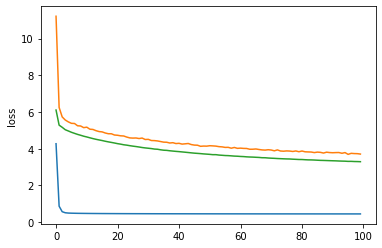

In [23]:
import pandas as pd
import numpy as np
# try Ratings_vip_moderateS.csv
ratingsdf = pd.read_csv('Ratings_vip5.csv')
ratings = ratingsdf.to_numpy()
shuffled_order = np.arange(len(ratings))
np.random.shuffle(shuffled_order)
ratings        = ratings[shuffled_order]
# cross validation
divide_on = math.floor(len(ratings)*0.75)
train_ratings  = ratings[0:divide_on :]
test_ratings   = ratings[divide_on: :]
print('training:', train_ratings.shape)
print('testing:', test_ratings.shape)
pmf = PMF(n_feature=100, epsilon=0.1, lam=0.1, n_epoches=100, n_batches=1000)
pmf.fit(train_ratings, test_ratings)
import matplotlib.pyplot as plt
print(pmf.train_loss, pmf.test_loss, pmf.test_mse)
plt.plot(pmf.train_loss)
plt.plot(pmf.test_loss)
plt.plot(pmf.test_mse)

plt.ylabel('loss')
plt.show()

In [24]:
import pandas as pd
import numpy as np
# try Ratings_vip_moderateS.csv
ratingsdf = pd.read_csv('Ratings_vip5_item5.csv')
ratings = ratingsdf.to_numpy()
shuffled_order = np.arange(len(ratings))
np.random.shuffle(shuffled_order)
ratings        = ratings[shuffled_order]
# cross validation
divide_on = math.floor(len(ratings)*0.75)
train_ratings  = ratings[0:divide_on :]
test_ratings   = ratings[divide_on: :]
print('training:', train_ratings.shape)
print('testing:', test_ratings.shape)
pmf = PMF(n_feature=100, epsilon=0.1, lam=0.1, n_epoches=500, n_batches=1000)
pmf.fit(train_ratings, test_ratings)


training: (144061, 3)
testing: (48021, 3)


[2020-04-05T01:04:32.274427+08:00] Epoch 1
[2020-04-05T01:04:32.275421+08:00] Training loss:	3.746172
[2020-04-05T01:04:32.275421+08:00] Testing loss:	10.112546
[2020-04-05T01:04:32.275421+08:00] Testing MSE:	4.434697
[2020-04-05T01:04:39.930517+08:00] Epoch 2
[2020-04-05T01:04:39.930517+08:00] Training loss:	0.755062
[2020-04-05T01:04:39.930517+08:00] Testing loss:	4.517992
[2020-04-05T01:04:39.930517+08:00] Testing MSE:	3.510156
[2020-04-05T01:04:47.183531+08:00] Epoch 3
[2020-04-05T01:04:47.183531+08:00] Training loss:	0.538690
[2020-04-05T01:04:47.183531+08:00] Testing loss:	3.950450
[2020-04-05T01:04:47.183531+08:00] Testing MSE:	3.395171
[2020-04-05T01:04:54.867377+08:00] Epoch 4
[2020-04-05T01:04:54.867377+08:00] Training loss:	0.498460
[2020-04-05T01:04:54.868338+08:00] Testing loss:	3.798137
[2020-04-05T01:04:54.868338+08:00] Testing MSE:	3.265196
[2020-04-05T01:05:02.087340+08:00] Epoch 5
[2020-04-05T01:05:02.087340+08:00] Training loss:	0.486470
[2020-04-05T01:05:02.087340+0

[2020-04-05T01:09:17.880953+08:00] Epoch 39
[2020-04-05T01:09:17.880953+08:00] Training loss:	0.452240
[2020-04-05T01:09:17.880953+08:00] Testing loss:	2.598786
[2020-04-05T01:09:17.880953+08:00] Testing MSE:	2.144248
[2020-04-05T01:09:25.815542+08:00] Epoch 40
[2020-04-05T01:09:25.816542+08:00] Training loss:	0.451857
[2020-04-05T01:09:25.816542+08:00] Testing loss:	2.540797
[2020-04-05T01:09:25.816542+08:00] Testing MSE:	2.126227
[2020-04-05T01:09:33.026810+08:00] Epoch 41
[2020-04-05T01:09:33.027812+08:00] Training loss:	0.451727
[2020-04-05T01:09:33.027812+08:00] Testing loss:	2.576882
[2020-04-05T01:09:33.027812+08:00] Testing MSE:	2.110154
[2020-04-05T01:09:40.739112+08:00] Epoch 42
[2020-04-05T01:09:40.739112+08:00] Training loss:	0.451544
[2020-04-05T01:09:40.739112+08:00] Testing loss:	2.541655
[2020-04-05T01:09:40.739112+08:00] Testing MSE:	2.097953
[2020-04-05T01:09:48.302541+08:00] Epoch 43
[2020-04-05T01:09:48.302541+08:00] Training loss:	0.451292
[2020-04-05T01:09:48.3028

[2020-04-05T01:14:10.597757+08:00] Epoch 77
[2020-04-05T01:14:10.597757+08:00] Training loss:	0.446984
[2020-04-05T01:14:10.597757+08:00] Testing loss:	2.219762
[2020-04-05T01:14:10.597757+08:00] Testing MSE:	1.750765
[2020-04-05T01:14:18.198572+08:00] Epoch 78
[2020-04-05T01:14:18.198572+08:00] Training loss:	0.446898
[2020-04-05T01:14:18.198572+08:00] Testing loss:	2.185392
[2020-04-05T01:14:18.198572+08:00] Testing MSE:	1.745742
[2020-04-05T01:14:25.582458+08:00] Epoch 79
[2020-04-05T01:14:25.582458+08:00] Training loss:	0.446781
[2020-04-05T01:14:25.582458+08:00] Testing loss:	2.185935
[2020-04-05T01:14:25.582458+08:00] Testing MSE:	1.745939
[2020-04-05T01:14:33.294273+08:00] Epoch 80
[2020-04-05T01:14:33.295284+08:00] Training loss:	0.446811
[2020-04-05T01:14:33.295284+08:00] Testing loss:	2.186396
[2020-04-05T01:14:33.295284+08:00] Testing MSE:	1.733615
[2020-04-05T01:14:40.447045+08:00] Epoch 81
[2020-04-05T01:14:40.448079+08:00] Training loss:	0.446761
[2020-04-05T01:14:40.4480

[2020-04-05T01:19:00.869338+08:00] Epoch 115
[2020-04-05T01:19:00.869338+08:00] Training loss:	0.445191
[2020-04-05T01:19:00.870308+08:00] Testing loss:	2.017910
[2020-04-05T01:19:00.870308+08:00] Testing MSE:	1.575873
[2020-04-05T01:19:08.453933+08:00] Epoch 116
[2020-04-05T01:19:08.453933+08:00] Training loss:	0.444976
[2020-04-05T01:19:08.453933+08:00] Testing loss:	2.006250
[2020-04-05T01:19:08.453933+08:00] Testing MSE:	1.573775
[2020-04-05T01:19:16.148932+08:00] Epoch 117
[2020-04-05T01:19:16.148932+08:00] Training loss:	0.445142
[2020-04-05T01:19:16.148932+08:00] Testing loss:	1.987992
[2020-04-05T01:19:16.148932+08:00] Testing MSE:	1.572182
[2020-04-05T01:19:23.359555+08:00] Epoch 118
[2020-04-05T01:19:23.359555+08:00] Training loss:	0.445008
[2020-04-05T01:19:23.359555+08:00] Testing loss:	1.990280
[2020-04-05T01:19:23.359555+08:00] Testing MSE:	1.566281
[2020-04-05T01:19:30.835145+08:00] Epoch 119
[2020-04-05T01:19:30.835145+08:00] Training loss:	0.445099
[2020-04-05T01:19:30

[2020-04-05T01:23:48.608335+08:00] Epoch 153
[2020-04-05T01:23:48.608335+08:00] Training loss:	0.444115
[2020-04-05T01:23:48.608335+08:00] Testing loss:	1.910168
[2020-04-05T01:23:48.608335+08:00] Testing MSE:	1.475556
[2020-04-05T01:23:55.885426+08:00] Epoch 154
[2020-04-05T01:23:55.885426+08:00] Training loss:	0.444137
[2020-04-05T01:23:55.885426+08:00] Testing loss:	1.910907
[2020-04-05T01:23:55.885426+08:00] Testing MSE:	1.475110
[2020-04-05T01:24:03.432984+08:00] Epoch 155
[2020-04-05T01:24:03.432984+08:00] Training loss:	0.444116
[2020-04-05T01:24:03.432984+08:00] Testing loss:	1.892915
[2020-04-05T01:24:03.432984+08:00] Testing MSE:	1.474434
[2020-04-05T01:24:10.868261+08:00] Epoch 156
[2020-04-05T01:24:10.868261+08:00] Training loss:	0.444200
[2020-04-05T01:24:10.868261+08:00] Testing loss:	1.904795
[2020-04-05T01:24:10.868261+08:00] Testing MSE:	1.470487
[2020-04-05T01:24:18.072802+08:00] Epoch 157
[2020-04-05T01:24:18.072802+08:00] Training loss:	0.444141
[2020-04-05T01:24:18

[2020-04-05T01:28:36.110505+08:00] Epoch 191
[2020-04-05T01:28:36.110505+08:00] Training loss:	0.443609
[2020-04-05T01:28:36.110505+08:00] Testing loss:	1.852097
[2020-04-05T01:28:36.110505+08:00] Testing MSE:	1.413335
[2020-04-05T01:28:43.369988+08:00] Epoch 192
[2020-04-05T01:28:43.370990+08:00] Training loss:	0.443650
[2020-04-05T01:28:43.370990+08:00] Testing loss:	1.841163
[2020-04-05T01:28:43.370990+08:00] Testing MSE:	1.414059
[2020-04-05T01:28:50.795017+08:00] Epoch 193
[2020-04-05T01:28:50.796016+08:00] Training loss:	0.443641
[2020-04-05T01:28:50.796016+08:00] Testing loss:	1.839674
[2020-04-05T01:28:50.796016+08:00] Testing MSE:	1.414450
[2020-04-05T01:28:58.491275+08:00] Epoch 194
[2020-04-05T01:28:58.492274+08:00] Training loss:	0.443765
[2020-04-05T01:28:58.492274+08:00] Testing loss:	1.833974
[2020-04-05T01:28:58.492274+08:00] Testing MSE:	1.414449
[2020-04-05T01:29:05.745433+08:00] Epoch 195
[2020-04-05T01:29:05.746436+08:00] Training loss:	0.443514
[2020-04-05T01:29:05

[2020-04-05T01:33:23.639525+08:00] Epoch 229
[2020-04-05T01:33:23.639525+08:00] Training loss:	0.443360
[2020-04-05T01:33:23.639525+08:00] Testing loss:	1.798093
[2020-04-05T01:33:23.639525+08:00] Testing MSE:	1.380058
[2020-04-05T01:33:30.923854+08:00] Epoch 230
[2020-04-05T01:33:30.924479+08:00] Training loss:	0.443369
[2020-04-05T01:33:30.924479+08:00] Testing loss:	1.813791
[2020-04-05T01:33:30.924479+08:00] Testing MSE:	1.374780
[2020-04-05T01:33:38.313562+08:00] Epoch 231
[2020-04-05T01:33:38.313562+08:00] Training loss:	0.443200
[2020-04-05T01:33:38.313922+08:00] Testing loss:	1.819278
[2020-04-05T01:33:38.313922+08:00] Testing MSE:	1.375049
[2020-04-05T01:33:46.470172+08:00] Epoch 232
[2020-04-05T01:33:46.471173+08:00] Training loss:	0.443386
[2020-04-05T01:33:46.471173+08:00] Testing loss:	1.793900
[2020-04-05T01:33:46.471173+08:00] Testing MSE:	1.376856
[2020-04-05T01:33:53.645901+08:00] Epoch 233
[2020-04-05T01:33:53.645901+08:00] Training loss:	0.443382
[2020-04-05T01:33:53

[2020-04-05T01:38:10.246159+08:00] Epoch 267
[2020-04-05T01:38:10.247162+08:00] Training loss:	0.443059
[2020-04-05T01:38:10.247162+08:00] Testing loss:	1.776716
[2020-04-05T01:38:10.247162+08:00] Testing MSE:	1.354019
[2020-04-05T01:38:18.302486+08:00] Epoch 268
[2020-04-05T01:38:18.302486+08:00] Training loss:	0.443087
[2020-04-05T01:38:18.302486+08:00] Testing loss:	1.789257
[2020-04-05T01:38:18.302486+08:00] Testing MSE:	1.353791
[2020-04-05T01:38:25.564065+08:00] Epoch 269
[2020-04-05T01:38:25.564065+08:00] Training loss:	0.443097
[2020-04-05T01:38:25.564065+08:00] Testing loss:	1.795029
[2020-04-05T01:38:25.565047+08:00] Testing MSE:	1.349576
[2020-04-05T01:38:33.276630+08:00] Epoch 270
[2020-04-05T01:38:33.276630+08:00] Training loss:	0.443043
[2020-04-05T01:38:33.276630+08:00] Testing loss:	1.779660
[2020-04-05T01:38:33.276630+08:00] Testing MSE:	1.356530
[2020-04-05T01:38:40.657827+08:00] Epoch 271
[2020-04-05T01:38:40.657827+08:00] Training loss:	0.443176
[2020-04-05T01:38:40

[2020-04-05T01:42:56.768758+08:00] Epoch 305
[2020-04-05T01:42:56.769762+08:00] Training loss:	0.442961
[2020-04-05T01:42:56.769762+08:00] Testing loss:	1.770084
[2020-04-05T01:42:56.769762+08:00] Testing MSE:	1.334061
[2020-04-05T01:43:04.612023+08:00] Epoch 306
[2020-04-05T01:43:04.613334+08:00] Training loss:	0.442970
[2020-04-05T01:43:04.613334+08:00] Testing loss:	1.755736
[2020-04-05T01:43:04.613334+08:00] Testing MSE:	1.339122
[2020-04-05T01:43:12.230255+08:00] Epoch 307
[2020-04-05T01:43:12.230255+08:00] Training loss:	0.442989
[2020-04-05T01:43:12.230255+08:00] Testing loss:	1.747422
[2020-04-05T01:43:12.230255+08:00] Testing MSE:	1.338796
[2020-04-05T01:43:20.166890+08:00] Epoch 308
[2020-04-05T01:43:20.166890+08:00] Training loss:	0.442972
[2020-04-05T01:43:20.166890+08:00] Testing loss:	1.762953
[2020-04-05T01:43:20.167851+08:00] Testing MSE:	1.335309
[2020-04-05T01:43:27.471992+08:00] Epoch 309
[2020-04-05T01:43:27.471992+08:00] Training loss:	0.442907
[2020-04-05T01:43:27

[2020-04-05T01:47:45.466822+08:00] Epoch 343
[2020-04-05T01:47:45.466822+08:00] Training loss:	0.442731
[2020-04-05T01:47:45.466822+08:00] Testing loss:	1.730721
[2020-04-05T01:47:45.466822+08:00] Testing MSE:	1.320963
[2020-04-05T01:47:53.258105+08:00] Epoch 344
[2020-04-05T01:47:53.258105+08:00] Training loss:	0.442847
[2020-04-05T01:47:53.258105+08:00] Testing loss:	1.745665
[2020-04-05T01:47:53.258105+08:00] Testing MSE:	1.320552
[2020-04-05T01:48:00.512104+08:00] Epoch 345
[2020-04-05T01:48:00.513194+08:00] Training loss:	0.442777
[2020-04-05T01:48:00.513194+08:00] Testing loss:	1.756827
[2020-04-05T01:48:00.513194+08:00] Testing MSE:	1.323338
[2020-04-05T01:48:08.324503+08:00] Epoch 346
[2020-04-05T01:48:08.324503+08:00] Training loss:	0.442815
[2020-04-05T01:48:08.325470+08:00] Testing loss:	1.734337
[2020-04-05T01:48:08.325470+08:00] Testing MSE:	1.320436
[2020-04-05T01:48:15.853316+08:00] Epoch 347
[2020-04-05T01:48:15.853316+08:00] Training loss:	0.442779
[2020-04-05T01:48:15

[2020-04-05T01:52:32.340119+08:00] Epoch 381
[2020-04-05T01:52:32.340119+08:00] Training loss:	0.442689
[2020-04-05T01:52:32.340119+08:00] Testing loss:	1.749708
[2020-04-05T01:52:32.341122+08:00] Testing MSE:	1.312385
[2020-04-05T01:52:40.025142+08:00] Epoch 382
[2020-04-05T01:52:40.025142+08:00] Training loss:	0.442720
[2020-04-05T01:52:40.025142+08:00] Testing loss:	1.755662
[2020-04-05T01:52:40.026144+08:00] Testing MSE:	1.312590
[2020-04-05T01:52:47.464416+08:00] Epoch 383
[2020-04-05T01:52:47.465416+08:00] Training loss:	0.442732
[2020-04-05T01:52:47.465416+08:00] Testing loss:	1.745785
[2020-04-05T01:52:47.466416+08:00] Testing MSE:	1.309087
[2020-04-05T01:52:55.151073+08:00] Epoch 384
[2020-04-05T01:52:55.151073+08:00] Training loss:	0.442730
[2020-04-05T01:52:55.151073+08:00] Testing loss:	1.743590
[2020-04-05T01:52:55.151073+08:00] Testing MSE:	1.308836
[2020-04-05T01:53:03.938446+08:00] Epoch 385
[2020-04-05T01:53:03.939446+08:00] Training loss:	0.442647
[2020-04-05T01:53:03

[2020-04-05T01:57:22.515110+08:00] Epoch 419
[2020-04-05T01:57:22.515110+08:00] Training loss:	0.442704
[2020-04-05T01:57:22.515110+08:00] Testing loss:	1.729461
[2020-04-05T01:57:22.516126+08:00] Testing MSE:	1.305294
[2020-04-05T01:57:30.137356+08:00] Epoch 420
[2020-04-05T01:57:30.137356+08:00] Training loss:	0.442773
[2020-04-05T01:57:30.137356+08:00] Testing loss:	1.711749
[2020-04-05T01:57:30.137356+08:00] Testing MSE:	1.302900
[2020-04-05T01:57:37.267313+08:00] Epoch 421
[2020-04-05T01:57:37.268314+08:00] Training loss:	0.442569
[2020-04-05T01:57:37.268529+08:00] Testing loss:	1.731671
[2020-04-05T01:57:37.268618+08:00] Testing MSE:	1.304918
[2020-04-05T01:57:46.344844+08:00] Epoch 422
[2020-04-05T01:57:46.345787+08:00] Training loss:	0.442580
[2020-04-05T01:57:46.345787+08:00] Testing loss:	1.729952
[2020-04-05T01:57:46.345787+08:00] Testing MSE:	1.303445
[2020-04-05T01:57:56.294759+08:00] Epoch 423
[2020-04-05T01:57:56.294759+08:00] Training loss:	0.442707
[2020-04-05T01:57:56

[2020-04-05T02:02:13.495177+08:00] Epoch 457
[2020-04-05T02:02:13.495177+08:00] Training loss:	0.442723
[2020-04-05T02:02:13.495177+08:00] Testing loss:	1.708982
[2020-04-05T02:02:13.495177+08:00] Testing MSE:	1.296198
[2020-04-05T02:02:20.710334+08:00] Epoch 458
[2020-04-05T02:02:20.711335+08:00] Training loss:	0.442715
[2020-04-05T02:02:20.711335+08:00] Testing loss:	1.735184
[2020-04-05T02:02:20.711335+08:00] Testing MSE:	1.299650
[2020-04-05T02:02:28.431365+08:00] Epoch 459
[2020-04-05T02:02:28.431365+08:00] Training loss:	0.442618
[2020-04-05T02:02:28.432313+08:00] Testing loss:	1.719361
[2020-04-05T02:02:28.432313+08:00] Testing MSE:	1.294487
[2020-04-05T02:02:35.699671+08:00] Epoch 460
[2020-04-05T02:02:35.699671+08:00] Training loss:	0.442685
[2020-04-05T02:02:35.699671+08:00] Testing loss:	1.723999
[2020-04-05T02:02:35.699671+08:00] Testing MSE:	1.295377
[2020-04-05T02:02:43.133938+08:00] Epoch 461
[2020-04-05T02:02:43.134940+08:00] Training loss:	0.442514
[2020-04-05T02:02:43

[2020-04-05T02:07:00.979567+08:00] Epoch 495
[2020-04-05T02:07:00.980571+08:00] Training loss:	0.442480
[2020-04-05T02:07:00.980571+08:00] Testing loss:	1.709933
[2020-04-05T02:07:00.980571+08:00] Testing MSE:	1.288827
[2020-04-05T02:07:08.575142+08:00] Epoch 496
[2020-04-05T02:07:08.576141+08:00] Training loss:	0.442524
[2020-04-05T02:07:08.576141+08:00] Testing loss:	1.730301
[2020-04-05T02:07:08.576141+08:00] Testing MSE:	1.293593
[2020-04-05T02:07:16.381011+08:00] Epoch 497
[2020-04-05T02:07:16.381011+08:00] Training loss:	0.442552
[2020-04-05T02:07:16.381011+08:00] Testing loss:	1.730164
[2020-04-05T02:07:16.381011+08:00] Testing MSE:	1.292441
[2020-04-05T02:07:23.623941+08:00] Epoch 498
[2020-04-05T02:07:23.623941+08:00] Training loss:	0.442712
[2020-04-05T02:07:23.623941+08:00] Testing loss:	1.713016
[2020-04-05T02:07:23.623941+08:00] Testing MSE:	1.291838
[2020-04-05T02:07:30.973941+08:00] Epoch 499
[2020-04-05T02:07:30.974872+08:00] Training loss:	0.442555
[2020-04-05T02:07:30

[3.746172011051904, 0.7550618706285895, 0.538690002468852, 0.49845986673864356, 0.48647012935740896, 0.48106610781759396, 0.47741706403217715, 0.47466288676479923, 0.4725404892790187, 0.47058871104144345, 0.468886764590063, 0.4676744583113307, 0.4660356289072183, 0.4650414029799109, 0.46396742133656826, 0.46294674967793026, 0.4619746901798847, 0.4612462272403912, 0.4605763491331066, 0.459861021925883, 0.45914151644099266, 0.45857138595932273, 0.4579922960884507, 0.45742157966679475, 0.4570498375180267, 0.45644097111573356, 0.4561322053647648, 0.4556658109769098, 0.4551814648862425, 0.4547898707219701, 0.45454643730881394, 0.45423606066284816, 0.45401384445959775, 0.45357103871762394, 0.45318319250154615, 0.4529486631338942, 0.4526280307217551, 0.45241017916801723, 0.4522402794703264, 0.45185693138742444, 0.45172666703835085, 0.4515440858149879, 0.45129160755422987, 0.45113740467241265, 0.4507415966092896, 0.45067811459034157, 0.4504949548647976, 0.4503804958072102, 0.45006319595788846,

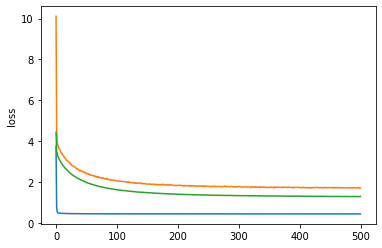

In [25]:
import matplotlib.pyplot as plt
print(pmf.train_loss, pmf.test_loss, pmf.test_mse)
plt.plot(pmf.train_loss)
plt.plot(pmf.test_loss)
plt.plot(pmf.test_mse)

plt.ylabel('loss')
plt.show()

training: (162615, 3)
testing: (54206, 3)


[2020-04-05T02:07:48.158343+08:00] Epoch 1
[2020-04-05T02:07:48.158343+08:00] Training loss:	3.899583
[2020-04-05T02:07:48.159347+08:00] Testing loss:	10.510645
[2020-04-05T02:07:48.159347+08:00] Testing MSE:	5.431896
[2020-04-05T02:07:56.654501+08:00] Epoch 2
[2020-04-05T02:07:56.654501+08:00] Training loss:	0.725710
[2020-04-05T02:07:56.654501+08:00] Testing loss:	5.529777
[2020-04-05T02:07:56.654501+08:00] Testing MSE:	4.563694
[2020-04-05T02:08:05.642283+08:00] Epoch 3
[2020-04-05T02:08:05.642283+08:00] Training loss:	0.510798
[2020-04-05T02:08:05.643368+08:00] Testing loss:	4.996142
[2020-04-05T02:08:05.643595+08:00] Testing MSE:	4.456519
[2020-04-05T02:08:14.581407+08:00] Epoch 4
[2020-04-05T02:08:14.582407+08:00] Training loss:	0.477823
[2020-04-05T02:08:14.582407+08:00] Testing loss:	4.864875
[2020-04-05T02:08:14.582407+08:00] Testing MSE:	4.332321
[2020-04-05T02:08:23.353968+08:00] Epoch 5
[2020-04-05T02:08:23.353968+08:00] Training loss:	0.468403
[2020-04-05T02:08:23.353968+0

[2020-04-05T02:13:14.644985+08:00] Epoch 39
[2020-04-05T02:13:14.644985+08:00] Training loss:	0.431270
[2020-04-05T02:13:14.644985+08:00] Testing loss:	3.425164
[2020-04-05T02:13:14.645950+08:00] Testing MSE:	2.993115
[2020-04-05T02:13:23.744803+08:00] Epoch 40
[2020-04-05T02:13:23.745438+08:00] Training loss:	0.430935
[2020-04-05T02:13:23.745438+08:00] Testing loss:	3.389899
[2020-04-05T02:13:23.745438+08:00] Testing MSE:	2.973495
[2020-04-05T02:13:32.155558+08:00] Epoch 41
[2020-04-05T02:13:32.155558+08:00] Training loss:	0.430614
[2020-04-05T02:13:32.156527+08:00] Testing loss:	3.376790
[2020-04-05T02:13:32.156527+08:00] Testing MSE:	2.953736
[2020-04-05T02:13:40.940338+08:00] Epoch 42
[2020-04-05T02:13:40.940338+08:00] Training loss:	0.430298
[2020-04-05T02:13:40.940338+08:00] Testing loss:	3.362551
[2020-04-05T02:13:40.940338+08:00] Testing MSE:	2.934912
[2020-04-05T02:13:49.232531+08:00] Epoch 43
[2020-04-05T02:13:49.232531+08:00] Training loss:	0.430017
[2020-04-05T02:13:49.2325

[2020-04-05T02:18:41.480289+08:00] Epoch 77
[2020-04-05T02:18:41.480289+08:00] Training loss:	0.423350
[2020-04-05T02:18:41.480289+08:00] Testing loss:	2.920383
[2020-04-05T02:18:41.480289+08:00] Testing MSE:	2.496953
[2020-04-05T02:18:50.270899+08:00] Epoch 78
[2020-04-05T02:18:50.270899+08:00] Training loss:	0.423223
[2020-04-05T02:18:50.270899+08:00] Testing loss:	2.898649
[2020-04-05T02:18:50.270899+08:00] Testing MSE:	2.488975
[2020-04-05T02:18:58.778555+08:00] Epoch 79
[2020-04-05T02:18:58.778555+08:00] Training loss:	0.423101
[2020-04-05T02:18:58.778555+08:00] Testing loss:	2.887451
[2020-04-05T02:18:58.778555+08:00] Testing MSE:	2.480396
[2020-04-05T02:19:07.596946+08:00] Epoch 80
[2020-04-05T02:19:07.596946+08:00] Training loss:	0.422962
[2020-04-05T02:19:07.596946+08:00] Testing loss:	2.891905
[2020-04-05T02:19:07.596946+08:00] Testing MSE:	2.472771
[2020-04-05T02:19:16.292826+08:00] Epoch 81
[2020-04-05T02:19:16.293824+08:00] Training loss:	0.422851
[2020-04-05T02:19:16.2938

[3.899582571929322, 0.7257095617883196, 0.510797638713822, 0.4778227025287105, 0.4684025508464005, 0.4636602810462853, 0.460261749212825, 0.45751259745488604, 0.45520286807253646, 0.4531878379093085, 0.4513753413527654, 0.4497967770382156, 0.4483580078953546, 0.447036479834196, 0.4458525818421005, 0.4447411854353961, 0.4437246862102742, 0.44277617458426977, 0.44189163262756576, 0.44106392945061873, 0.440293912141862, 0.4395512437852509, 0.4388569625005824, 0.4382008254496586, 0.4375919179180742, 0.43701225362393437, 0.4364360450626253, 0.4359071336232093, 0.4353948358546078, 0.434900269732316, 0.43443514644685993, 0.4339821429717109, 0.43355317452676834, 0.43312612798402117, 0.43271760839428797, 0.4323530009989093, 0.43198788259740617, 0.4316209653648147, 0.43127048872561313, 0.4309347843638871, 0.43061372280523846, 0.4302984174479366, 0.43001690560837635, 0.42970431734771863, 0.4294136615299005, 0.42914489862218647, 0.428873993024733, 0.4286094488317377, 0.4283639578217537, 0.42810705

[2020-04-05T02:21:58.688731+08:00] Epoch 100
[2020-04-05T02:21:58.689275+08:00] Training loss:	0.420942
[2020-04-05T02:21:58.689275+08:00] Testing loss:	2.744364
[2020-04-05T02:21:58.690258+08:00] Testing MSE:	2.342629


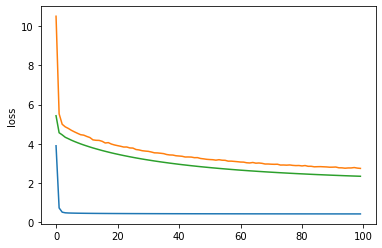

In [26]:
import pandas as pd
import numpy as np
# try Ratings_vip_moderateS.csv
ratingsdf = pd.read_csv('Ratings_vip5_moderateS.csv')
ratings = ratingsdf.to_numpy()
shuffled_order = np.arange(len(ratings))
np.random.shuffle(shuffled_order)
ratings        = ratings[shuffled_order]
# cross validation
divide_on = math.floor(len(ratings)*0.75)
train_ratings  = ratings[0:divide_on :]
test_ratings   = ratings[divide_on: :]
print('training:', train_ratings.shape)
print('testing:', test_ratings.shape)
pmf = PMF(n_feature=100, epsilon=0.1, lam=0.1, n_epoches=100, n_batches=1000)
pmf.fit(train_ratings, test_ratings)
import matplotlib.pyplot as plt
print(pmf.train_loss, pmf.test_loss, pmf.test_mse)
plt.plot(pmf.train_loss)
plt.plot(pmf.test_loss)
plt.plot(pmf.test_mse)

plt.ylabel('loss')
plt.show()

training: (144061, 3)
testing: (48021, 3)


[2020-04-05T02:22:06.723306+08:00] Epoch 1
[2020-04-05T02:22:06.723306+08:00] Training loss:	3.470635
[2020-04-05T02:22:06.723700+08:00] Testing loss:	9.500999
[2020-04-05T02:22:06.723827+08:00] Testing MSE:	3.913782
[2020-04-05T02:22:14.715636+08:00] Epoch 2
[2020-04-05T02:22:14.715636+08:00] Training loss:	0.653839
[2020-04-05T02:22:14.715636+08:00] Testing loss:	3.952622
[2020-04-05T02:22:14.715636+08:00] Testing MSE:	2.970676
[2020-04-05T02:22:22.194220+08:00] Epoch 3
[2020-04-05T02:22:22.194220+08:00] Training loss:	0.496637
[2020-04-05T02:22:22.194220+08:00] Testing loss:	3.412207
[2020-04-05T02:22:22.194220+08:00] Testing MSE:	2.860092
[2020-04-05T02:22:29.967437+08:00] Epoch 4
[2020-04-05T02:22:29.968437+08:00] Training loss:	0.471935
[2020-04-05T02:22:29.968437+08:00] Testing loss:	3.283417
[2020-04-05T02:22:29.968437+08:00] Testing MSE:	2.725068
[2020-04-05T02:22:37.365145+08:00] Epoch 5
[2020-04-05T02:22:37.365145+08:00] Training loss:	0.464261
[2020-04-05T02:22:37.365145+08

[2020-04-05T02:27:01.754439+08:00] Epoch 39
[2020-04-05T02:27:01.755441+08:00] Training loss:	0.428416
[2020-04-05T02:27:01.755441+08:00] Testing loss:	1.801138
[2020-04-05T02:27:01.755441+08:00] Testing MSE:	1.371036
[2020-04-05T02:27:09.054496+08:00] Epoch 40
[2020-04-05T02:27:09.054496+08:00] Training loss:	0.428075
[2020-04-05T02:27:09.054496+08:00] Testing loss:	1.788647
[2020-04-05T02:27:09.055461+08:00] Testing MSE:	1.352348
[2020-04-05T02:27:16.916732+08:00] Epoch 41
[2020-04-05T02:27:16.916732+08:00] Training loss:	0.427771
[2020-04-05T02:27:16.916732+08:00] Testing loss:	1.770699
[2020-04-05T02:27:16.916732+08:00] Testing MSE:	1.333802
[2020-04-05T02:27:24.217945+08:00] Epoch 42
[2020-04-05T02:27:24.217945+08:00] Training loss:	0.427454
[2020-04-05T02:27:24.217945+08:00] Testing loss:	1.748673
[2020-04-05T02:27:24.217945+08:00] Testing MSE:	1.315573
[2020-04-05T02:27:31.804035+08:00] Epoch 43
[2020-04-05T02:27:31.804035+08:00] Training loss:	0.427163
[2020-04-05T02:27:31.8040

[2020-04-05T02:31:55.032020+08:00] Epoch 77
[2020-04-05T02:31:55.032020+08:00] Training loss:	0.420821
[2020-04-05T02:31:55.033021+08:00] Testing loss:	1.309353
[2020-04-05T02:31:55.033021+08:00] Testing MSE:	0.912185
[2020-04-05T02:32:02.483525+08:00] Epoch 78
[2020-04-05T02:32:02.484285+08:00] Training loss:	0.420708
[2020-04-05T02:32:02.484285+08:00] Testing loss:	1.320752
[2020-04-05T02:32:02.484285+08:00] Testing MSE:	0.904857
[2020-04-05T02:32:10.993148+08:00] Epoch 79
[2020-04-05T02:32:10.994149+08:00] Training loss:	0.420594
[2020-04-05T02:32:10.994149+08:00] Testing loss:	1.314688
[2020-04-05T02:32:10.994149+08:00] Testing MSE:	0.897652
[2020-04-05T02:32:18.426803+08:00] Epoch 80
[2020-04-05T02:32:18.426803+08:00] Training loss:	0.420481
[2020-04-05T02:32:18.426803+08:00] Testing loss:	1.311037
[2020-04-05T02:32:18.426803+08:00] Testing MSE:	0.891330
[2020-04-05T02:32:26.245276+08:00] Epoch 81
[2020-04-05T02:32:26.246279+08:00] Training loss:	0.420377
[2020-04-05T02:32:26.2462

[2020-04-05T02:36:46.740198+08:00] Epoch 115
[2020-04-05T02:36:46.740198+08:00] Training loss:	0.417777
[2020-04-05T02:36:46.740198+08:00] Testing loss:	1.130632
[2020-04-05T02:36:46.740198+08:00] Testing MSE:	0.728466
[2020-04-05T02:36:54.493583+08:00] Epoch 116
[2020-04-05T02:36:54.495121+08:00] Training loss:	0.417729
[2020-04-05T02:36:54.495347+08:00] Testing loss:	1.137886
[2020-04-05T02:36:54.495553+08:00] Testing MSE:	0.725199
[2020-04-05T02:37:01.874383+08:00] Epoch 117
[2020-04-05T02:37:01.875378+08:00] Training loss:	0.417686
[2020-04-05T02:37:01.875378+08:00] Testing loss:	1.143207
[2020-04-05T02:37:01.875378+08:00] Testing MSE:	0.722284
[2020-04-05T02:37:09.907006+08:00] Epoch 118
[2020-04-05T02:37:09.907006+08:00] Training loss:	0.417624
[2020-04-05T02:37:09.907006+08:00] Testing loss:	1.128291
[2020-04-05T02:37:09.907006+08:00] Testing MSE:	0.719091
[2020-04-05T02:37:17.272656+08:00] Epoch 119
[2020-04-05T02:37:17.272656+08:00] Training loss:	0.417583
[2020-04-05T02:37:17

[2020-04-05T02:41:37.982030+08:00] Epoch 153
[2020-04-05T02:41:37.982030+08:00] Training loss:	0.416308
[2020-04-05T02:41:37.982030+08:00] Testing loss:	1.041910
[2020-04-05T02:41:37.982030+08:00] Testing MSE:	0.643473
[2020-04-05T02:41:45.754310+08:00] Epoch 154
[2020-04-05T02:41:45.754310+08:00] Training loss:	0.416279
[2020-04-05T02:41:45.754310+08:00] Testing loss:	1.056764
[2020-04-05T02:41:45.755311+08:00] Testing MSE:	0.641809
[2020-04-05T02:41:53.111972+08:00] Epoch 155
[2020-04-05T02:41:53.111972+08:00] Training loss:	0.416252
[2020-04-05T02:41:53.111972+08:00] Testing loss:	1.042628
[2020-04-05T02:41:53.111972+08:00] Testing MSE:	0.640466
[2020-04-05T02:42:00.947926+08:00] Epoch 156
[2020-04-05T02:42:00.947926+08:00] Training loss:	0.416230
[2020-04-05T02:42:00.947926+08:00] Testing loss:	1.051973
[2020-04-05T02:42:00.947926+08:00] Testing MSE:	0.639007
[2020-04-05T02:42:08.273922+08:00] Epoch 157
[2020-04-05T02:42:08.273922+08:00] Training loss:	0.416203
[2020-04-05T02:42:08

[2020-04-05T02:46:31.875241+08:00] Epoch 191
[2020-04-05T02:46:31.876269+08:00] Training loss:	0.415515
[2020-04-05T02:46:31.876269+08:00] Testing loss:	1.015881
[2020-04-05T02:46:31.876269+08:00] Testing MSE:	0.599957
[2020-04-05T02:46:39.185188+08:00] Epoch 192
[2020-04-05T02:46:39.185188+08:00] Training loss:	0.415503
[2020-04-05T02:46:39.185188+08:00] Testing loss:	1.013254
[2020-04-05T02:46:39.185188+08:00] Testing MSE:	0.598948
[2020-04-05T02:46:47.345917+08:00] Epoch 193
[2020-04-05T02:46:47.346918+08:00] Training loss:	0.415486
[2020-04-05T02:46:47.346918+08:00] Testing loss:	1.018197
[2020-04-05T02:46:47.346918+08:00] Testing MSE:	0.598262
[2020-04-05T02:46:54.617680+08:00] Epoch 194
[2020-04-05T02:46:54.617680+08:00] Training loss:	0.415466
[2020-04-05T02:46:54.617680+08:00] Testing loss:	1.005165
[2020-04-05T02:46:54.617680+08:00] Testing MSE:	0.597391
[2020-04-05T02:47:02.428031+08:00] Epoch 195
[2020-04-05T02:47:02.428031+08:00] Training loss:	0.415454
[2020-04-05T02:47:02

[2020-04-05T02:51:21.749513+08:00] Epoch 229
[2020-04-05T02:51:21.750514+08:00] Training loss:	0.415044
[2020-04-05T02:51:21.750514+08:00] Testing loss:	0.992851
[2020-04-05T02:51:21.750514+08:00] Testing MSE:	0.575456
[2020-04-05T02:51:29.114630+08:00] Epoch 230
[2020-04-05T02:51:29.115585+08:00] Training loss:	0.415042
[2020-04-05T02:51:29.115585+08:00] Testing loss:	0.985456
[2020-04-05T02:51:29.115585+08:00] Testing MSE:	0.574790
[2020-04-05T02:51:36.915281+08:00] Epoch 231
[2020-04-05T02:51:36.916282+08:00] Training loss:	0.415026
[2020-04-05T02:51:36.916282+08:00] Testing loss:	0.972411
[2020-04-05T02:51:36.916282+08:00] Testing MSE:	0.574531
[2020-04-05T02:51:44.380069+08:00] Epoch 232
[2020-04-05T02:51:44.380069+08:00] Training loss:	0.415023
[2020-04-05T02:51:44.380069+08:00] Testing loss:	0.976158
[2020-04-05T02:51:44.381067+08:00] Testing MSE:	0.573799
[2020-04-05T02:51:52.214989+08:00] Epoch 233
[2020-04-05T02:51:52.214989+08:00] Training loss:	0.415013
[2020-04-05T02:51:52

[2020-04-05T02:56:12.692423+08:00] Epoch 267
[2020-04-05T02:56:12.692423+08:00] Training loss:	0.414765
[2020-04-05T02:56:12.692423+08:00] Testing loss:	0.950303
[2020-04-05T02:56:12.693425+08:00] Testing MSE:	0.560750
[2020-04-05T02:56:20.751769+08:00] Epoch 268
[2020-04-05T02:56:20.751769+08:00] Training loss:	0.414759
[2020-04-05T02:56:20.751769+08:00] Testing loss:	0.964058
[2020-04-05T02:56:20.751769+08:00] Testing MSE:	0.560360
[2020-04-05T02:56:28.157026+08:00] Epoch 269
[2020-04-05T02:56:28.157026+08:00] Training loss:	0.414751
[2020-04-05T02:56:28.157026+08:00] Testing loss:	0.940547
[2020-04-05T02:56:28.157026+08:00] Testing MSE:	0.560106
[2020-04-05T02:56:35.866313+08:00] Epoch 270
[2020-04-05T02:56:35.866313+08:00] Training loss:	0.414743
[2020-04-05T02:56:35.866313+08:00] Testing loss:	0.945795
[2020-04-05T02:56:35.866313+08:00] Testing MSE:	0.559947
[2020-04-05T02:56:43.493757+08:00] Epoch 271
[2020-04-05T02:56:43.494760+08:00] Training loss:	0.414742
[2020-04-05T02:56:43

[2020-04-05T03:01:10.780067+08:00] Epoch 305
[2020-04-05T03:01:10.781068+08:00] Training loss:	0.414581
[2020-04-05T03:01:10.781068+08:00] Testing loss:	0.957863
[2020-04-05T03:01:10.781068+08:00] Testing MSE:	0.551387
[2020-04-05T03:01:18.118816+08:00] Epoch 306
[2020-04-05T03:01:18.120400+08:00] Training loss:	0.414575
[2020-04-05T03:01:18.120400+08:00] Testing loss:	0.972322
[2020-04-05T03:01:18.120781+08:00] Testing MSE:	0.551195
[2020-04-05T03:01:26.480161+08:00] Epoch 307
[2020-04-05T03:01:26.480161+08:00] Training loss:	0.414573
[2020-04-05T03:01:26.481124+08:00] Testing loss:	0.945410
[2020-04-05T03:01:26.481124+08:00] Testing MSE:	0.550921
[2020-04-05T03:01:33.815204+08:00] Epoch 308
[2020-04-05T03:01:33.815204+08:00] Training loss:	0.414568
[2020-04-05T03:01:33.815204+08:00] Testing loss:	0.961768
[2020-04-05T03:01:33.816206+08:00] Testing MSE:	0.550760
[2020-04-05T03:01:41.676623+08:00] Epoch 309
[2020-04-05T03:01:41.676623+08:00] Training loss:	0.414564
[2020-04-05T03:01:41

[2020-04-05T03:06:03.174924+08:00] Epoch 343
[2020-04-05T03:06:03.174924+08:00] Training loss:	0.414455
[2020-04-05T03:06:03.174924+08:00] Testing loss:	0.938640
[2020-04-05T03:06:03.174924+08:00] Testing MSE:	0.545099
[2020-04-05T03:06:10.605303+08:00] Epoch 344
[2020-04-05T03:06:10.605303+08:00] Training loss:	0.414455
[2020-04-05T03:06:10.605303+08:00] Testing loss:	0.946125
[2020-04-05T03:06:10.605303+08:00] Testing MSE:	0.545125
[2020-04-05T03:06:18.403751+08:00] Epoch 345
[2020-04-05T03:06:18.403751+08:00] Training loss:	0.414452
[2020-04-05T03:06:18.403751+08:00] Testing loss:	0.947553
[2020-04-05T03:06:18.403751+08:00] Testing MSE:	0.545105
[2020-04-05T03:06:25.939085+08:00] Epoch 346
[2020-04-05T03:06:25.940087+08:00] Training loss:	0.414450
[2020-04-05T03:06:25.940087+08:00] Testing loss:	0.956591
[2020-04-05T03:06:25.940087+08:00] Testing MSE:	0.544845
[2020-04-05T03:06:34.110956+08:00] Epoch 347
[2020-04-05T03:06:34.110956+08:00] Training loss:	0.414450
[2020-04-05T03:06:34

[2020-04-05T03:10:54.608534+08:00] Epoch 381
[2020-04-05T03:10:54.608534+08:00] Training loss:	0.414377
[2020-04-05T03:10:54.608534+08:00] Testing loss:	0.940392
[2020-04-05T03:10:54.608534+08:00] Testing MSE:	0.540780
[2020-04-05T03:11:02.545286+08:00] Epoch 382
[2020-04-05T03:11:02.546287+08:00] Training loss:	0.414377
[2020-04-05T03:11:02.546287+08:00] Testing loss:	0.933507
[2020-04-05T03:11:02.546287+08:00] Testing MSE:	0.540665
[2020-04-05T03:11:09.986500+08:00] Epoch 383
[2020-04-05T03:11:09.986500+08:00] Training loss:	0.414376
[2020-04-05T03:11:09.986500+08:00] Testing loss:	0.930531
[2020-04-05T03:11:09.986500+08:00] Testing MSE:	0.540796
[2020-04-05T03:11:17.913239+08:00] Epoch 384
[2020-04-05T03:11:17.913239+08:00] Training loss:	0.414374
[2020-04-05T03:11:17.914063+08:00] Testing loss:	0.935002
[2020-04-05T03:11:17.914063+08:00] Testing MSE:	0.540769
[2020-04-05T03:11:25.511178+08:00] Epoch 385
[2020-04-05T03:11:25.511178+08:00] Training loss:	0.414369
[2020-04-05T03:11:25

[2020-04-05T03:15:47.195944+08:00] Epoch 419
[2020-04-05T03:15:47.195944+08:00] Training loss:	0.414320
[2020-04-05T03:15:47.195944+08:00] Testing loss:	0.951931
[2020-04-05T03:15:47.195944+08:00] Testing MSE:	0.537927
[2020-04-05T03:15:55.366435+08:00] Epoch 420
[2020-04-05T03:15:55.366435+08:00] Training loss:	0.414320
[2020-04-05T03:15:55.367436+08:00] Testing loss:	0.935996
[2020-04-05T03:15:55.367436+08:00] Testing MSE:	0.537736
[2020-04-05T03:16:03.310304+08:00] Epoch 421
[2020-04-05T03:16:03.310304+08:00] Training loss:	0.414316
[2020-04-05T03:16:03.310304+08:00] Testing loss:	0.936801
[2020-04-05T03:16:03.311443+08:00] Testing MSE:	0.537677
[2020-04-05T03:16:11.124094+08:00] Epoch 422
[2020-04-05T03:16:11.124094+08:00] Training loss:	0.414319
[2020-04-05T03:16:11.124094+08:00] Testing loss:	0.926915
[2020-04-05T03:16:11.124094+08:00] Testing MSE:	0.537693
[2020-04-05T03:16:18.520005+08:00] Epoch 423
[2020-04-05T03:16:18.520005+08:00] Training loss:	0.414315
[2020-04-05T03:16:18

[2020-04-05T03:20:40.316933+08:00] Epoch 457
[2020-04-05T03:20:40.316933+08:00] Training loss:	0.414273
[2020-04-05T03:20:40.317934+08:00] Testing loss:	0.952530
[2020-04-05T03:20:40.317934+08:00] Testing MSE:	0.535447
[2020-04-05T03:20:47.683570+08:00] Epoch 458
[2020-04-05T03:20:47.684398+08:00] Training loss:	0.414276
[2020-04-05T03:20:47.684398+08:00] Testing loss:	0.938349
[2020-04-05T03:20:47.684398+08:00] Testing MSE:	0.535487
[2020-04-05T03:20:55.540461+08:00] Epoch 459
[2020-04-05T03:20:55.540461+08:00] Training loss:	0.414274
[2020-04-05T03:20:55.540461+08:00] Testing loss:	0.951697
[2020-04-05T03:20:55.540461+08:00] Testing MSE:	0.535297
[2020-04-05T03:21:02.935852+08:00] Epoch 460
[2020-04-05T03:21:02.935852+08:00] Training loss:	0.414277
[2020-04-05T03:21:02.935852+08:00] Testing loss:	0.941699
[2020-04-05T03:21:02.935852+08:00] Testing MSE:	0.535272
[2020-04-05T03:21:11.095845+08:00] Epoch 461
[2020-04-05T03:21:11.095845+08:00] Training loss:	0.414274
[2020-04-05T03:21:11

[2020-04-05T03:25:34.798835+08:00] Epoch 495
[2020-04-05T03:25:34.798835+08:00] Training loss:	0.414248
[2020-04-05T03:25:34.798835+08:00] Testing loss:	0.920941
[2020-04-05T03:25:34.798835+08:00] Testing MSE:	0.533634
[2020-04-05T03:25:42.774313+08:00] Epoch 496
[2020-04-05T03:25:42.774313+08:00] Training loss:	0.414245
[2020-04-05T03:25:42.774313+08:00] Testing loss:	0.931016
[2020-04-05T03:25:42.774313+08:00] Testing MSE:	0.533649
[2020-04-05T03:25:50.139874+08:00] Epoch 497
[2020-04-05T03:25:50.139874+08:00] Training loss:	0.414247
[2020-04-05T03:25:50.139874+08:00] Testing loss:	0.935091
[2020-04-05T03:25:50.139874+08:00] Testing MSE:	0.533773
[2020-04-05T03:25:58.080763+08:00] Epoch 498
[2020-04-05T03:25:58.080763+08:00] Training loss:	0.414253
[2020-04-05T03:25:58.080763+08:00] Testing loss:	0.952809
[2020-04-05T03:25:58.080763+08:00] Testing MSE:	0.533590
[2020-04-05T03:26:05.365014+08:00] Epoch 499
[2020-04-05T03:26:05.366015+08:00] Training loss:	0.414245
[2020-04-05T03:26:05

[3.470634508040083, 0.6538388598065437, 0.4966372062979697, 0.47193521076473144, 0.46426061745000013, 0.4599461902693571, 0.4567116942785154, 0.4540712098989277, 0.45182805712706653, 0.4498781729039829, 0.44814490924499, 0.4465835566361831, 0.44519096476171705, 0.4439102027119845, 0.442749598733789, 0.4416590723700379, 0.44067152594486836, 0.4397451165419046, 0.4388719088587169, 0.4380600008711284, 0.4373003128003967, 0.43657160995907174, 0.43589531407617294, 0.4352452999588043, 0.4346277028681206, 0.43405463876973915, 0.4335069224585669, 0.43296977459556785, 0.43246513018066546, 0.4319894202451107, 0.4315265403540353, 0.4310822958833632, 0.4306514517699209, 0.430243469088347, 0.42985459148511324, 0.42947382307164667, 0.4291089417053192, 0.42875371233593845, 0.4284160563519008, 0.4280752334560768, 0.4277706817506535, 0.4274544160571417, 0.4271626854318727, 0.42687955193219546, 0.42659629758677364, 0.42632416060986267, 0.4260712556020414, 0.42581675774871625, 0.42557265049103804, 0.4253

[2020-04-05T03:26:13.269241+08:00] Epoch 500
[2020-04-05T03:26:13.269241+08:00] Training loss:	0.414244
[2020-04-05T03:26:13.270204+08:00] Testing loss:	0.945810
[2020-04-05T03:26:13.270204+08:00] Testing MSE:	0.533470


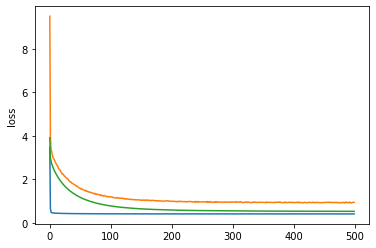

In [27]:
import pandas as pd
import numpy as np
# try Ratings_vip_moderateS.csv
ratingsdf = pd.read_csv('Ratings_vip5_item5_moderateS.csv')
ratings = ratingsdf.to_numpy()
shuffled_order = np.arange(len(ratings))
np.random.shuffle(shuffled_order)
ratings        = ratings[shuffled_order]
# cross validation
divide_on = math.floor(len(ratings)*0.75)
train_ratings  = ratings[0:divide_on :]
test_ratings   = ratings[divide_on: :]
print('training:', train_ratings.shape)
print('testing:', test_ratings.shape)
pmf = PMF(n_feature=100, epsilon=0.1, lam=0.1, n_epoches=500, n_batches=1000)
pmf.fit(train_ratings, test_ratings)
import matplotlib.pyplot as plt
print(pmf.train_loss, pmf.test_loss, pmf.test_mse)
plt.plot(pmf.train_loss)
plt.plot(pmf.test_loss)
plt.plot(pmf.test_mse)

plt.ylabel('loss')
plt.show()

training: (162615, 3)
testing: (54206, 3)


[2020-04-05T03:26:22.398527+08:00] Epoch 1
[2020-04-05T03:26:22.398527+08:00] Training loss:	3.304150
[2020-04-05T03:26:22.398527+08:00] Testing loss:	8.443587
[2020-04-05T03:26:22.398527+08:00] Testing MSE:	4.682521
[2020-04-05T03:26:31.145570+08:00] Epoch 2
[2020-04-05T03:26:31.145570+08:00] Training loss:	0.702373
[2020-04-05T03:26:31.145570+08:00] Testing loss:	4.708067
[2020-04-05T03:26:31.145570+08:00] Testing MSE:	3.922830
[2020-04-05T03:26:39.637191+08:00] Epoch 3
[2020-04-05T03:26:39.637191+08:00] Training loss:	0.480240
[2020-04-05T03:26:39.638192+08:00] Testing loss:	4.348204
[2020-04-05T03:26:39.638192+08:00] Testing MSE:	3.840467
[2020-04-05T03:26:48.499712+08:00] Epoch 4
[2020-04-05T03:26:48.500723+08:00] Training loss:	0.456133
[2020-04-05T03:26:48.500723+08:00] Testing loss:	4.255029
[2020-04-05T03:26:48.500723+08:00] Testing MSE:	3.754950
[2020-04-05T03:26:56.826116+08:00] Epoch 5
[2020-04-05T03:26:56.827076+08:00] Training loss:	0.448947
[2020-04-05T03:26:56.827076+08

[2020-04-05T03:31:52.753689+08:00] Epoch 39
[2020-04-05T03:31:52.754686+08:00] Training loss:	0.418435
[2020-04-05T03:31:52.754686+08:00] Testing loss:	3.285268
[2020-04-05T03:31:52.754686+08:00] Testing MSE:	2.877231
[2020-04-05T03:32:01.026230+08:00] Epoch 40
[2020-04-05T03:32:01.027231+08:00] Training loss:	0.418260
[2020-04-05T03:32:01.027231+08:00] Testing loss:	3.301600
[2020-04-05T03:32:01.027231+08:00] Testing MSE:	2.866718
[2020-04-05T03:32:09.869866+08:00] Epoch 41
[2020-04-05T03:32:09.869866+08:00] Training loss:	0.417995
[2020-04-05T03:32:09.869866+08:00] Testing loss:	3.259983
[2020-04-05T03:32:09.869866+08:00] Testing MSE:	2.854203
[2020-04-05T03:32:18.126370+08:00] Epoch 42
[2020-04-05T03:32:18.126370+08:00] Training loss:	0.417829
[2020-04-05T03:32:18.126370+08:00] Testing loss:	3.247809
[2020-04-05T03:32:18.126370+08:00] Testing MSE:	2.841317
[2020-04-05T03:32:26.953175+08:00] Epoch 43
[2020-04-05T03:32:26.953175+08:00] Training loss:	0.417533
[2020-04-05T03:32:26.9538

[2020-04-05T03:37:19.601774+08:00] Epoch 77
[2020-04-05T03:37:19.601774+08:00] Training loss:	0.412947
[2020-04-05T03:37:19.601774+08:00] Testing loss:	2.935549
[2020-04-05T03:37:19.601774+08:00] Testing MSE:	2.546740
[2020-04-05T03:37:28.437229+08:00] Epoch 78
[2020-04-05T03:37:28.437229+08:00] Training loss:	0.412855
[2020-04-05T03:37:28.437229+08:00] Testing loss:	2.964672
[2020-04-05T03:37:28.437229+08:00] Testing MSE:	2.546954
[2020-04-05T03:37:36.734021+08:00] Epoch 79
[2020-04-05T03:37:36.734021+08:00] Training loss:	0.412603
[2020-04-05T03:37:36.734021+08:00] Testing loss:	2.934234
[2020-04-05T03:37:36.734021+08:00] Testing MSE:	2.538032
[2020-04-05T03:37:45.881358+08:00] Epoch 80
[2020-04-05T03:37:45.881358+08:00] Training loss:	0.412732
[2020-04-05T03:37:45.881358+08:00] Testing loss:	2.919923
[2020-04-05T03:37:45.881358+08:00] Testing MSE:	2.531843
[2020-04-05T03:37:54.538948+08:00] Epoch 81
[2020-04-05T03:37:54.538948+08:00] Training loss:	0.412507
[2020-04-05T03:37:54.5389

[3.3041496830959445, 0.7023729866172668, 0.48023976557811554, 0.456132678686517, 0.44894739500708863, 0.44520312283329333, 0.44228110644431334, 0.4399330347184292, 0.437982368903653, 0.43622159623476314, 0.43469388663168507, 0.43334785387333474, 0.432153465668034, 0.43106553295227695, 0.4300083017693994, 0.42908893771013745, 0.42822966784301425, 0.4274456361627975, 0.42671223619209425, 0.4261284367571212, 0.42545448738524694, 0.4248492712361915, 0.4244045288914753, 0.4238115103305694, 0.4233834837326785, 0.42289019861544197, 0.4224301782089706, 0.4219212400396944, 0.4216188412829165, 0.42121227019391955, 0.4208732774913795, 0.4205755391883106, 0.4202073164339615, 0.41986570887813257, 0.41963814548394385, 0.41925931627310875, 0.41902664290883823, 0.41874920807543975, 0.4184353919026358, 0.41825992787082233, 0.41799515409188204, 0.41782920997810585, 0.41753291105272744, 0.41734964134922437, 0.4171915581486044, 0.41696572054183084, 0.41672656347263837, 0.41651054496545165, 0.4163855684188

[2020-04-05T03:40:40.257295+08:00] Epoch 100
[2020-04-05T03:40:40.258296+08:00] Training loss:	0.411328
[2020-04-05T03:40:40.258296+08:00] Testing loss:	2.835974
[2020-04-05T03:40:40.258296+08:00] Testing MSE:	2.443211


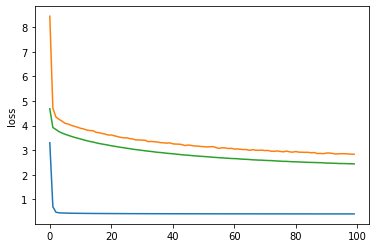

In [28]:
# try Ratings_vip_sa.csv
ratingsdf = pd.read_csv('Ratings_vip5_sa.csv')
ratings = ratingsdf.to_numpy()
shuffled_order = np.arange(len(ratings))
np.random.shuffle(shuffled_order)
ratings        = ratings[shuffled_order]
# cross validation
divide_on = math.floor(len(ratings)*0.75)
train_ratings  = ratings[0:divide_on :]
test_ratings   = ratings[divide_on: :]
print('training:', train_ratings.shape)
print('testing:', test_ratings.shape)
pmf = PMF(n_feature=100, epsilon=0.1, lam=0.1, n_epoches=100, n_batches=1000)
pmf.fit(train_ratings, test_ratings)
import matplotlib.pyplot as plt
print(pmf.train_loss, pmf.test_loss, pmf.test_mse)
plt.plot(pmf.train_loss)
plt.plot(pmf.test_loss)
plt.plot(pmf.test_mse)

plt.ylabel('loss')
plt.show()

training: (144061, 3)
testing: (48021, 3)


[2020-04-05T03:40:48.074227+08:00] Epoch 1
[2020-04-05T03:40:48.074227+08:00] Training loss:	2.977536
[2020-04-05T03:40:48.074227+08:00] Testing loss:	7.706626
[2020-04-05T03:40:48.075231+08:00] Testing MSE:	3.572802
[2020-04-05T03:40:55.977711+08:00] Epoch 2
[2020-04-05T03:40:55.978710+08:00] Training loss:	0.621443
[2020-04-05T03:40:55.978710+08:00] Testing loss:	3.607810
[2020-04-05T03:40:55.978710+08:00] Testing MSE:	2.767510
[2020-04-05T03:41:03.766640+08:00] Epoch 3
[2020-04-05T03:41:03.766640+08:00] Training loss:	0.470239
[2020-04-05T03:41:03.766640+08:00] Testing loss:	3.156890
[2020-04-05T03:41:03.766640+08:00] Testing MSE:	2.679102
[2020-04-05T03:41:11.604423+08:00] Epoch 4
[2020-04-05T03:41:11.604423+08:00] Training loss:	0.451971
[2020-04-05T03:41:11.604423+08:00] Testing loss:	3.079241
[2020-04-05T03:41:11.605388+08:00] Testing MSE:	2.585705
[2020-04-05T03:41:18.947224+08:00] Epoch 5
[2020-04-05T03:41:18.947224+08:00] Training loss:	0.446304
[2020-04-05T03:41:18.947224+08

[2020-04-05T03:45:38.431690+08:00] Epoch 39
[2020-04-05T03:45:38.431690+08:00] Training loss:	0.418036
[2020-04-05T03:45:38.431690+08:00] Testing loss:	2.110957
[2020-04-05T03:45:38.431690+08:00] Testing MSE:	1.705053
[2020-04-05T03:45:46.552363+08:00] Epoch 40
[2020-04-05T03:45:46.552363+08:00] Training loss:	0.417831
[2020-04-05T03:45:46.552363+08:00] Testing loss:	2.108379
[2020-04-05T03:45:46.552363+08:00] Testing MSE:	1.691113
[2020-04-05T03:45:53.873480+08:00] Epoch 41
[2020-04-05T03:45:53.873480+08:00] Training loss:	0.417519
[2020-04-05T03:45:53.873480+08:00] Testing loss:	2.088895
[2020-04-05T03:45:53.873480+08:00] Testing MSE:	1.680485
[2020-04-05T03:46:01.777567+08:00] Epoch 42
[2020-04-05T03:46:01.777567+08:00] Training loss:	0.417404
[2020-04-05T03:46:01.777567+08:00] Testing loss:	2.072651
[2020-04-05T03:46:01.777567+08:00] Testing MSE:	1.666126
[2020-04-05T03:46:09.480956+08:00] Epoch 43
[2020-04-05T03:46:09.480956+08:00] Training loss:	0.417247
[2020-04-05T03:46:09.4809

[2020-04-05T03:50:32.128500+08:00] Epoch 77
[2020-04-05T03:50:32.128500+08:00] Training loss:	0.413205
[2020-04-05T03:50:32.128500+08:00] Testing loss:	1.786990
[2020-04-05T03:50:32.128500+08:00] Testing MSE:	1.388106
[2020-04-05T03:50:39.553519+08:00] Epoch 78
[2020-04-05T03:50:39.553519+08:00] Training loss:	0.413186
[2020-04-05T03:50:39.553519+08:00] Testing loss:	1.791257
[2020-04-05T03:50:39.553519+08:00] Testing MSE:	1.385784
[2020-04-05T03:50:47.632224+08:00] Epoch 79
[2020-04-05T03:50:47.632224+08:00] Training loss:	0.413076
[2020-04-05T03:50:47.632224+08:00] Testing loss:	1.772438
[2020-04-05T03:50:47.632224+08:00] Testing MSE:	1.381603
[2020-04-05T03:50:54.968528+08:00] Epoch 80
[2020-04-05T03:50:54.968528+08:00] Training loss:	0.412992
[2020-04-05T03:50:54.968528+08:00] Testing loss:	1.779198
[2020-04-05T03:50:54.968528+08:00] Testing MSE:	1.376641
[2020-04-05T03:51:04.360048+08:00] Epoch 81
[2020-04-05T03:51:04.360048+08:00] Training loss:	0.412906
[2020-04-05T03:51:04.3600

[2020-04-05T03:55:25.940148+08:00] Epoch 115
[2020-04-05T03:55:25.940148+08:00] Training loss:	0.411516
[2020-04-05T03:55:25.940148+08:00] Testing loss:	1.650178
[2020-04-05T03:55:25.940148+08:00] Testing MSE:	1.245660
[2020-04-05T03:55:33.736141+08:00] Epoch 116
[2020-04-05T03:55:33.736141+08:00] Training loss:	0.411322
[2020-04-05T03:55:33.736141+08:00] Testing loss:	1.618462
[2020-04-05T03:55:33.736141+08:00] Testing MSE:	1.243126
[2020-04-05T03:55:41.610177+08:00] Epoch 117
[2020-04-05T03:55:41.610177+08:00] Training loss:	0.411269
[2020-04-05T03:55:41.610177+08:00] Testing loss:	1.640897
[2020-04-05T03:55:41.610177+08:00] Testing MSE:	1.238704
[2020-04-05T03:55:49.579089+08:00] Epoch 118
[2020-04-05T03:55:49.579089+08:00] Training loss:	0.411222
[2020-04-05T03:55:49.579089+08:00] Testing loss:	1.650184
[2020-04-05T03:55:49.579089+08:00] Testing MSE:	1.235069
[2020-04-05T03:55:56.959184+08:00] Epoch 119
[2020-04-05T03:55:56.959184+08:00] Training loss:	0.411261
[2020-04-05T03:55:56

[2020-04-05T04:00:24.684542+08:00] Epoch 153
[2020-04-05T04:00:24.684542+08:00] Training loss:	0.410535
[2020-04-05T04:00:24.684542+08:00] Testing loss:	1.555903
[2020-04-05T04:00:24.684542+08:00] Testing MSE:	1.163944
[2020-04-05T04:00:32.072523+08:00] Epoch 154
[2020-04-05T04:00:32.072523+08:00] Training loss:	0.410489
[2020-04-05T04:00:32.072523+08:00] Testing loss:	1.553821
[2020-04-05T04:00:32.072523+08:00] Testing MSE:	1.160686
[2020-04-05T04:00:39.906527+08:00] Epoch 155
[2020-04-05T04:00:39.906527+08:00] Training loss:	0.410525
[2020-04-05T04:00:39.906527+08:00] Testing loss:	1.557337
[2020-04-05T04:00:39.906527+08:00] Testing MSE:	1.157405
[2020-04-05T04:00:47.274976+08:00] Epoch 156
[2020-04-05T04:00:47.275694+08:00] Training loss:	0.410428
[2020-04-05T04:00:47.275694+08:00] Testing loss:	1.569513
[2020-04-05T04:00:47.276496+08:00] Testing MSE:	1.158513
[2020-04-05T04:00:55.683643+08:00] Epoch 157
[2020-04-05T04:00:55.683643+08:00] Training loss:	0.410505
[2020-04-05T04:00:55

[2020-04-05T04:05:18.064869+08:00] Epoch 191
[2020-04-05T04:05:18.064869+08:00] Training loss:	0.409951
[2020-04-05T04:05:18.064869+08:00] Testing loss:	1.497763
[2020-04-05T04:05:18.064869+08:00] Testing MSE:	1.115291
[2020-04-05T04:05:25.925636+08:00] Epoch 192
[2020-04-05T04:05:25.925636+08:00] Training loss:	0.409901
[2020-04-05T04:05:25.925636+08:00] Testing loss:	1.517429
[2020-04-05T04:05:25.925636+08:00] Testing MSE:	1.114589
[2020-04-05T04:05:33.331210+08:00] Epoch 193
[2020-04-05T04:05:33.332221+08:00] Training loss:	0.409946
[2020-04-05T04:05:33.332221+08:00] Testing loss:	1.494210
[2020-04-05T04:05:33.332221+08:00] Testing MSE:	1.113631
[2020-04-05T04:05:41.289858+08:00] Epoch 194
[2020-04-05T04:05:41.289858+08:00] Training loss:	0.410017
[2020-04-05T04:05:41.289858+08:00] Testing loss:	1.503402
[2020-04-05T04:05:41.289858+08:00] Testing MSE:	1.112773
[2020-04-05T04:05:48.644345+08:00] Epoch 195
[2020-04-05T04:05:48.644345+08:00] Training loss:	0.409981
[2020-04-05T04:05:48

[2020-04-05T04:10:11.980945+08:00] Epoch 229
[2020-04-05T04:10:11.981947+08:00] Training loss:	0.409761
[2020-04-05T04:10:11.981947+08:00] Testing loss:	1.477376
[2020-04-05T04:10:11.981947+08:00] Testing MSE:	1.083137
[2020-04-05T04:10:19.571670+08:00] Epoch 230
[2020-04-05T04:10:19.572672+08:00] Training loss:	0.409689
[2020-04-05T04:10:19.572672+08:00] Testing loss:	1.480341
[2020-04-05T04:10:19.572672+08:00] Testing MSE:	1.084312
[2020-04-05T04:10:26.971905+08:00] Epoch 231
[2020-04-05T04:10:26.971905+08:00] Training loss:	0.409658
[2020-04-05T04:10:26.973131+08:00] Testing loss:	1.479239
[2020-04-05T04:10:26.973342+08:00] Testing MSE:	1.081918
[2020-04-05T04:10:34.712570+08:00] Epoch 232
[2020-04-05T04:10:34.712570+08:00] Training loss:	0.409719
[2020-04-05T04:10:34.712570+08:00] Testing loss:	1.466219
[2020-04-05T04:10:34.712570+08:00] Testing MSE:	1.082386
[2020-04-05T04:10:42.105940+08:00] Epoch 233
[2020-04-05T04:10:42.105940+08:00] Training loss:	0.409492
[2020-04-05T04:10:42

[2020-04-05T04:15:02.131387+08:00] Epoch 267
[2020-04-05T04:15:02.131387+08:00] Training loss:	0.409562
[2020-04-05T04:15:02.131387+08:00] Testing loss:	1.457190
[2020-04-05T04:15:02.132391+08:00] Testing MSE:	1.068576
[2020-04-05T04:15:09.645612+08:00] Epoch 268
[2020-04-05T04:15:09.645612+08:00] Training loss:	0.409423
[2020-04-05T04:15:09.645612+08:00] Testing loss:	1.442903
[2020-04-05T04:15:09.646615+08:00] Testing MSE:	1.060040
[2020-04-05T04:15:17.445641+08:00] Epoch 269
[2020-04-05T04:15:17.445641+08:00] Training loss:	0.409399
[2020-04-05T04:15:17.445641+08:00] Testing loss:	1.456667
[2020-04-05T04:15:17.445641+08:00] Testing MSE:	1.059136
[2020-04-05T04:15:25.145278+08:00] Epoch 270
[2020-04-05T04:15:25.145764+08:00] Training loss:	0.409513
[2020-04-05T04:15:25.145764+08:00] Testing loss:	1.446720
[2020-04-05T04:15:25.145764+08:00] Testing MSE:	1.067688
[2020-04-05T04:15:32.910896+08:00] Epoch 271
[2020-04-05T04:15:32.910896+08:00] Training loss:	0.409424
[2020-04-05T04:15:32

[2020-04-05T04:19:54.352980+08:00] Epoch 305
[2020-04-05T04:19:54.352980+08:00] Training loss:	0.409278
[2020-04-05T04:19:54.352980+08:00] Testing loss:	1.436480
[2020-04-05T04:19:54.352980+08:00] Testing MSE:	1.047506
[2020-04-05T04:20:01.884094+08:00] Epoch 306
[2020-04-05T04:20:01.884094+08:00] Training loss:	0.409299
[2020-04-05T04:20:01.884094+08:00] Testing loss:	1.456193
[2020-04-05T04:20:01.884094+08:00] Testing MSE:	1.045514
[2020-04-05T04:20:09.594227+08:00] Epoch 307
[2020-04-05T04:20:09.594227+08:00] Training loss:	0.409235
[2020-04-05T04:20:09.594227+08:00] Testing loss:	1.431872
[2020-04-05T04:20:09.595229+08:00] Testing MSE:	1.046065
[2020-04-05T04:20:16.903413+08:00] Epoch 308
[2020-04-05T04:20:16.903413+08:00] Training loss:	0.409284
[2020-04-05T04:20:16.903413+08:00] Testing loss:	1.438490
[2020-04-05T04:20:16.903413+08:00] Testing MSE:	1.040970
[2020-04-05T04:20:24.631026+08:00] Epoch 309
[2020-04-05T04:20:24.631026+08:00] Training loss:	0.409297
[2020-04-05T04:20:24

[2020-04-05T04:25:12.197261+08:00] Epoch 343
[2020-04-05T04:25:12.198263+08:00] Training loss:	0.409190
[2020-04-05T04:25:12.198263+08:00] Testing loss:	1.428945
[2020-04-05T04:25:12.198263+08:00] Testing MSE:	1.030084
[2020-04-05T04:25:19.602231+08:00] Epoch 344
[2020-04-05T04:25:19.603231+08:00] Training loss:	0.409135
[2020-04-05T04:25:19.603231+08:00] Testing loss:	1.404042
[2020-04-05T04:25:19.603231+08:00] Testing MSE:	1.033476
[2020-04-05T04:25:27.492470+08:00] Epoch 345
[2020-04-05T04:25:27.493470+08:00] Training loss:	0.409240
[2020-04-05T04:25:27.493470+08:00] Testing loss:	1.426899
[2020-04-05T04:25:27.493470+08:00] Testing MSE:	1.033807
[2020-04-05T04:25:34.774082+08:00] Epoch 346
[2020-04-05T04:25:34.774082+08:00] Training loss:	0.409176
[2020-04-05T04:25:34.774082+08:00] Testing loss:	1.431520
[2020-04-05T04:25:34.774082+08:00] Testing MSE:	1.034039
[2020-04-05T04:25:42.687126+08:00] Epoch 347
[2020-04-05T04:25:42.687126+08:00] Training loss:	0.409092
[2020-04-05T04:25:42

[2020-04-05T04:30:04.646806+08:00] Epoch 381
[2020-04-05T04:30:04.646806+08:00] Training loss:	0.409107
[2020-04-05T04:30:04.646806+08:00] Testing loss:	1.416291
[2020-04-05T04:30:04.646806+08:00] Testing MSE:	1.024189
[2020-04-05T04:30:12.747566+08:00] Epoch 382
[2020-04-05T04:30:12.748568+08:00] Training loss:	0.409185
[2020-04-05T04:30:12.748568+08:00] Testing loss:	1.419589
[2020-04-05T04:30:12.748568+08:00] Testing MSE:	1.025828
[2020-04-05T04:30:20.197001+08:00] Epoch 383
[2020-04-05T04:30:20.198004+08:00] Training loss:	0.409111
[2020-04-05T04:30:20.198004+08:00] Testing loss:	1.416831
[2020-04-05T04:30:20.198004+08:00] Testing MSE:	1.022569
[2020-04-05T04:30:27.726966+08:00] Epoch 384
[2020-04-05T04:30:27.726966+08:00] Training loss:	0.409040
[2020-04-05T04:30:27.726966+08:00] Testing loss:	1.406238
[2020-04-05T04:30:27.726966+08:00] Testing MSE:	1.022941
[2020-04-05T04:30:35.572092+08:00] Epoch 385
[2020-04-05T04:30:35.572092+08:00] Training loss:	0.409070
[2020-04-05T04:30:35

[2020-04-05T04:34:56.624195+08:00] Epoch 419
[2020-04-05T04:34:56.624195+08:00] Training loss:	0.409082
[2020-04-05T04:34:56.624195+08:00] Testing loss:	1.406389
[2020-04-05T04:34:56.624195+08:00] Testing MSE:	1.014666
[2020-04-05T04:35:04.398202+08:00] Epoch 420
[2020-04-05T04:35:04.398202+08:00] Training loss:	0.409055
[2020-04-05T04:35:04.398202+08:00] Testing loss:	1.412825
[2020-04-05T04:35:04.398202+08:00] Testing MSE:	1.018265
[2020-04-05T04:35:12.067519+08:00] Epoch 421
[2020-04-05T04:35:12.068521+08:00] Training loss:	0.409002
[2020-04-05T04:35:12.068521+08:00] Testing loss:	1.407869
[2020-04-05T04:35:12.068521+08:00] Testing MSE:	1.018359
[2020-04-05T04:35:20.253145+08:00] Epoch 422
[2020-04-05T04:35:20.253657+08:00] Training loss:	0.409047
[2020-04-05T04:35:20.253657+08:00] Testing loss:	1.409016
[2020-04-05T04:35:20.253657+08:00] Testing MSE:	1.014557
[2020-04-05T04:35:27.594665+08:00] Epoch 423
[2020-04-05T04:35:27.594665+08:00] Training loss:	0.409083
[2020-04-05T04:35:27

[2020-04-05T04:39:48.966811+08:00] Epoch 457
[2020-04-05T04:39:48.967809+08:00] Training loss:	0.409017
[2020-04-05T04:39:48.967809+08:00] Testing loss:	1.413448
[2020-04-05T04:39:48.967809+08:00] Testing MSE:	1.016056
[2020-04-05T04:39:56.312549+08:00] Epoch 458
[2020-04-05T04:39:56.312549+08:00] Training loss:	0.408931
[2020-04-05T04:39:56.312549+08:00] Testing loss:	1.406163
[2020-04-05T04:39:56.312549+08:00] Testing MSE:	1.012141
[2020-04-05T04:40:03.785693+08:00] Epoch 459
[2020-04-05T04:40:03.785693+08:00] Training loss:	0.409012
[2020-04-05T04:40:03.785693+08:00] Testing loss:	1.407362
[2020-04-05T04:40:03.786696+08:00] Testing MSE:	1.014406
[2020-04-05T04:40:11.737092+08:00] Epoch 460
[2020-04-05T04:40:11.737092+08:00] Training loss:	0.409011
[2020-04-05T04:40:11.737092+08:00] Testing loss:	1.390505
[2020-04-05T04:40:11.737092+08:00] Testing MSE:	1.012918
[2020-04-05T04:40:19.079682+08:00] Epoch 461
[2020-04-05T04:40:19.079682+08:00] Training loss:	0.408996
[2020-04-05T04:40:19

[2020-04-05T04:44:41.082236+08:00] Epoch 495
[2020-04-05T04:44:41.082236+08:00] Training loss:	0.408978
[2020-04-05T04:44:41.082236+08:00] Testing loss:	1.390453
[2020-04-05T04:44:41.083239+08:00] Testing MSE:	1.006627
[2020-04-05T04:44:48.534355+08:00] Epoch 496
[2020-04-05T04:44:48.534355+08:00] Training loss:	0.408969
[2020-04-05T04:44:48.535277+08:00] Testing loss:	1.408366
[2020-04-05T04:44:48.535277+08:00] Testing MSE:	1.010212
[2020-04-05T04:44:56.463585+08:00] Epoch 497
[2020-04-05T04:44:56.464586+08:00] Training loss:	0.408982
[2020-04-05T04:44:56.464586+08:00] Testing loss:	1.400556
[2020-04-05T04:44:56.464586+08:00] Testing MSE:	1.006523
[2020-04-05T04:45:03.849345+08:00] Epoch 498
[2020-04-05T04:45:03.849345+08:00] Training loss:	0.409067
[2020-04-05T04:45:03.850209+08:00] Testing loss:	1.389999
[2020-04-05T04:45:03.850209+08:00] Testing MSE:	1.008586
[2020-04-05T04:45:11.761971+08:00] Epoch 499
[2020-04-05T04:45:11.762972+08:00] Training loss:	0.408981
[2020-04-05T04:45:11

[2.9775364681492476, 0.6214428572517188, 0.4702387000205339, 0.4519706781459484, 0.4463041001487908, 0.44271730887754246, 0.44012399281974107, 0.43792309021263404, 0.4361824017129689, 0.4344270926603237, 0.433048900969154, 0.43185849490990635, 0.43072008644861853, 0.4295617075209216, 0.4287151644462884, 0.4279507266490039, 0.4270704329821288, 0.42634274375249426, 0.4256652178862781, 0.4250128858356202, 0.42450098911618095, 0.4238929343944518, 0.42342325897406163, 0.42297226540076327, 0.4224240805917054, 0.4221062525400026, 0.4216317767042985, 0.42121827024332403, 0.420816038468623, 0.42054948328868497, 0.420302199225628, 0.4198957932621228, 0.41967078302609, 0.41929588531748896, 0.41904467923564337, 0.4189015947081363, 0.41839300459184703, 0.41822369600627357, 0.4180361815795726, 0.41783133730790506, 0.41751878140150794, 0.4174044271814887, 0.41724726668248135, 0.41698082999172537, 0.41677714822104467, 0.4167017962098234, 0.41651138447739516, 0.4163351865145231, 0.4161217329653992, 0.4

[2020-04-05T04:45:19.322046+08:00] Epoch 500
[2020-04-05T04:45:19.323044+08:00] Training loss:	0.408990
[2020-04-05T04:45:19.323044+08:00] Testing loss:	1.391951
[2020-04-05T04:45:19.323044+08:00] Testing MSE:	1.010206


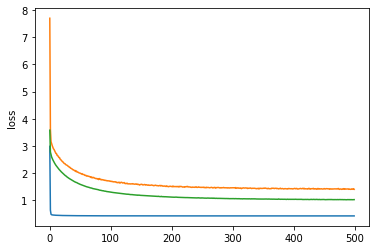

In [29]:

# try Ratings_vip_sa.csv
ratingsdf = pd.read_csv('Ratings_vip5_item5_sa.csv')
ratings = ratingsdf.to_numpy()
shuffled_order = np.arange(len(ratings))
np.random.shuffle(shuffled_order)
ratings        = ratings[shuffled_order]
# cross validation
divide_on = math.floor(len(ratings)*0.75)
train_ratings  = ratings[0:divide_on :]
test_ratings   = ratings[divide_on: :]
print('training:', train_ratings.shape)
print('testing:', test_ratings.shape)
pmf = PMF(n_feature=100, epsilon=0.1, lam=0.1, n_epoches=500, n_batches=1000)
pmf.fit(train_ratings, test_ratings)
import matplotlib.pyplot as plt
print(pmf.train_loss, pmf.test_loss, pmf.test_mse)
plt.plot(pmf.train_loss)
plt.plot(pmf.test_loss)
plt.plot(pmf.test_mse)

plt.ylabel('loss')
plt.show()